# Model Hybrid VARIMA-LSTM: Upaya Peningkatan Akurasi Peramalan Harga Saham

<div class="alert-success">
Nama :Dina Merlia Efendi
</div>

<div class="alert-danger">
Github : https://github.com/dinamerlia
</div>

## **VARIMA**

### **Membangkitkan Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from numpy import array
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import ConvLSTM2D
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from timeit import default_timer as timer

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [ ]:
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/S/Apple.csv", parse_dates = True, index_col = 0)
dataset

Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-03   28.950001   29.082500   28.690001   29.037500   27.095844   
2017-01-04   28.962500   29.127501   28.937500   29.004999   27.065521   
2017-01-05   28.980000   29.215000   28.952499   29.152500   27.203159   
2017-01-06   29.195000   29.540001   29.117500   29.477501   27.506422   
2017-01-09   29.487499   29.857500   29.485001   29.747499   27.758371   
...                ...         ...         ...         ...         ...   
2022-05-24  140.809998  141.970001  137.330002  140.360001  139.526840   
2022-05-25  138.429993  141.789993  138.339996  140.520004  139.685913   
2022-05-26  137.389999  144.339996  137.139999  143.779999  142.926544   
2022-05-27  145.389999  149.679993  145.259995  149.639999  148.751755   
2022-05-31  149.070007  150.660004  146.839996  148.839996  147.956528   

               Volume  
Date                   
2017-01-03  115127600  
2017-01-04   84472400  
2017-01-05   88774400  
2017-01-06  127007600  
2017-01-09  134247600  
...               ...  
2022-05-24  104132700  
2022-05-25   92482700  
2022-05-26   90601500  
2022-05-27   90978500  
2022-05-31  103718400  

[1362 rows x 6 columns]

In [ ]:
data = dataset[['Open','High','Low','Close']]

In [ ]:
data

Open        High         Low       Close
Date                                                      
2017-01-03   28.950001   29.082500   28.690001   29.037500
2017-01-04   28.962500   29.127501   28.937500   29.004999
2017-01-05   28.980000   29.215000   28.952499   29.152500
2017-01-06   29.195000   29.540001   29.117500   29.477501
2017-01-09   29.487499   29.857500   29.485001   29.747499
...                ...         ...         ...         ...
2022-05-24  140.809998  141.970001  137.330002  140.360001
2022-05-25  138.429993  141.789993  138.339996  140.520004
2022-05-26  137.389999  144.339996  137.139999  143.779999
2022-05-27  145.389999  149.679993  145.259995  149.639999
2022-05-31  149.070007  150.660004  146.839996  148.839996

[1362 rows x 4 columns]

## **Preprocessing**

### **Cek Missing Value**

In [ ]:
data.isnull().sum()

Open     0
High     0
Low      0
Close    0
dtype: int64

### **Cek Korelasi**

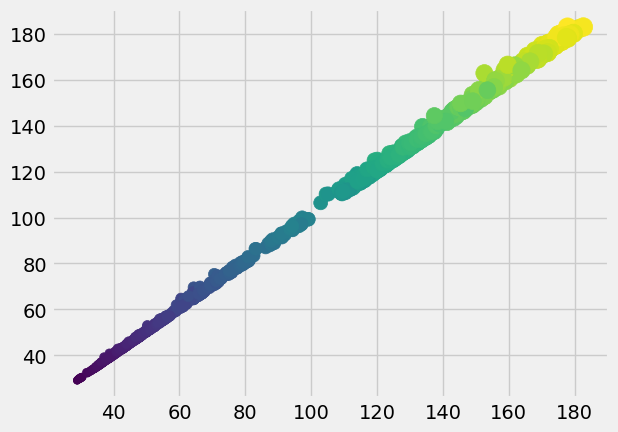

array([[1.        , 0.76369487, 0.84427443, ..., 0.80967371, 0.80279737,
        0.92323682],
       [0.76369487, 1.        , 0.9052711 , ..., 0.83199247, 0.80221135,
        0.87807771],
       [0.84427443, 0.9052711 , 1.        , ..., 0.98805493, 0.97913867,
        0.7904976 ],
       ...,
       [0.80967371, 0.83199247, 0.98805493, ..., 1.        , 0.99865401,
        0.70275565],
       [0.80279737, 0.80221135, 0.97913867, ..., 0.99865401, 1.        ,
        0.6766824 ],
       [0.92323682, 0.87807771, 0.7904976 , ..., 0.70275565, 0.6766824 ,
        1.        ]])

In [ ]:
plt.scatter(data["Open"], data["High"], data["Low"], data["Close"])
plt.show()
np.corrcoef(data, rowvar = True)

### **Plot Data Awal**

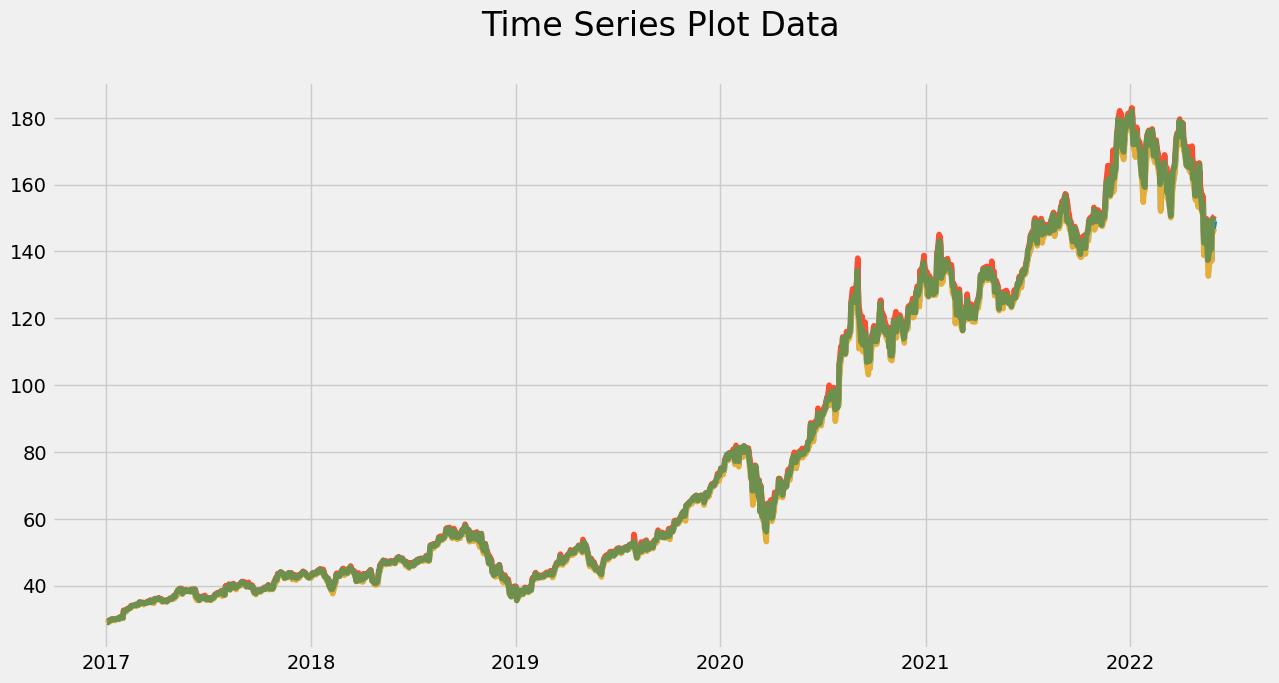

In [ ]:
plt.figure(figsize = (14,7))
plt.title('Time Series Plot Data\n', fontsize = 24)
plt.plot(data)
plt.show()

### **Cek stasioner data**

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluatidatabaruon metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
data.columns

Index(['Open', 'High', 'Low', 'Close'], dtype='object')

In [ ]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                   -0.395128
p-value                           0.910909
No Lags Used                      4.000000
Number of Observations Used    1357.000000
Critical Value (1%)              -3.435178
Critical Value (5%)              -2.863672
Critical Value (10%)             -2.567905
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                   -0.343216
p-value                           0.919157
No Lags Used                      6.000000
Number of Observations Used    1355.000000
Critical Value (1%)              -3.435185
Critical Value (5%)              -2.863675
Critical Value (10%)             -2.567907
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                   -0.434219
p-value                        

### **Differencing Data**

In [ ]:
data_diff = data.dropna().diff()
data_diff = data_diff.dropna()

In [ ]:
data_diff

Open      High       Low     Close
Date                                              
2017-01-04  0.012499  0.045001  0.247499 -0.032501
2017-01-05  0.017500  0.087499  0.014999  0.147501
2017-01-06  0.215000  0.325001  0.165001  0.325001
2017-01-09  0.292499  0.317499  0.367501  0.269998
2017-01-10  0.205000 -0.012501  0.090000  0.030001
...              ...       ...       ...       ...
2022-05-24  3.020005 -1.289994 -0.319992 -2.750000
2022-05-25 -2.380005 -0.180008  1.009994  0.160003
2022-05-26 -1.039994  2.550003 -1.199997  3.259995
2022-05-27  8.000000  5.339997  8.119996  5.860000
2022-05-31  3.680008  0.980011  1.580001 -0.800003

[1361 rows x 4 columns]

In [ ]:
for name, column in data_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(data_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Open
Test Statistic                -1.859156e+01
p-value                        2.073243e-30
No Lags Used                   3.000000e+00
Number of Observations Used    1.357000e+03
Critical Value (1%)           -3.435178e+00
Critical Value (5%)           -2.863672e+00
Critical Value (10%)          -2.567905e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: High
Test Statistic                -1.500453e+01
p-value                        1.077630e-27
No Lags Used                   5.000000e+00
Number of Observations Used    1.355000e+03
Critical Value (1%)           -3.435185e+00
Critical Value (5%)           -2.863675e+00
Critical Value (10%)          -2.567907e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Low
Test Statistic                -1.742830e+01
p-value                        4.782906e

### **Plot Data Differencing**

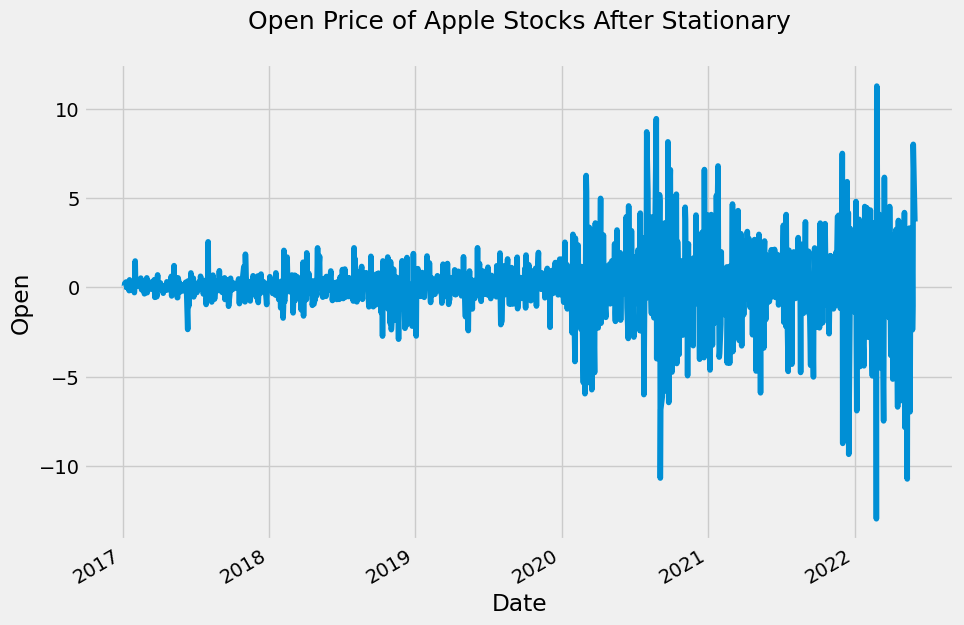

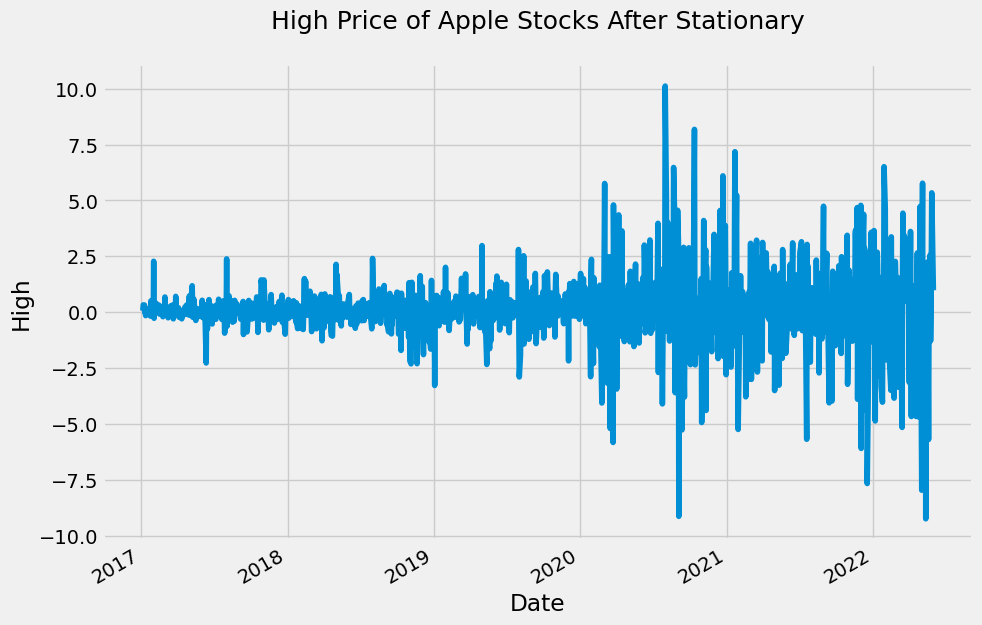

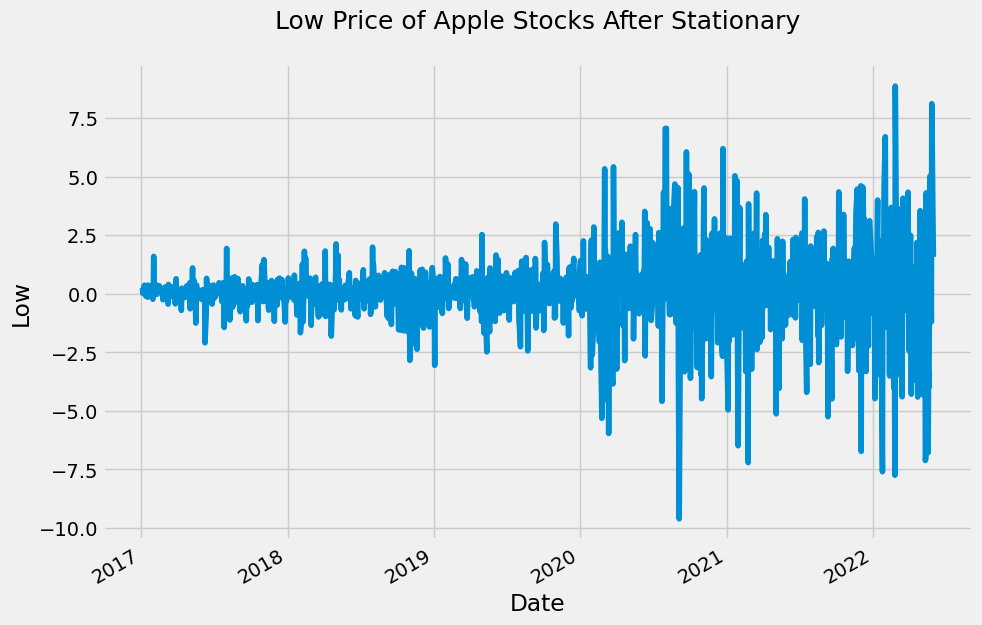

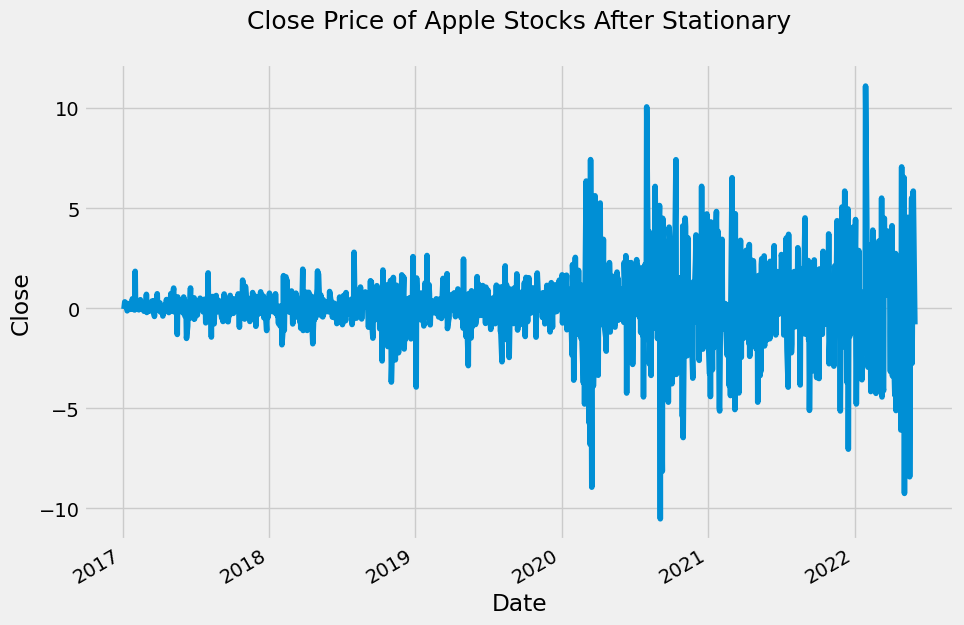

In [ ]:
for feature in data_diff:
    data_diff[str(feature)].plot(figsize = (10, 7))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} Price of Apple Stocks After Stationary\n", fontsize = 18)
    plt.show()

### **Tes Kointegrasi**

In [ ]:
def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(data_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Open   >  1865.94   > 40.1749   =>   True
High   >  1224.71   > 24.2761   =>   True
Low    >  609.24    > 12.3212   =>   True
Close  >  189.12    > 4.1296    =>   True


## **Model Terbaik**

### **Plot ACF dan PACF Open**

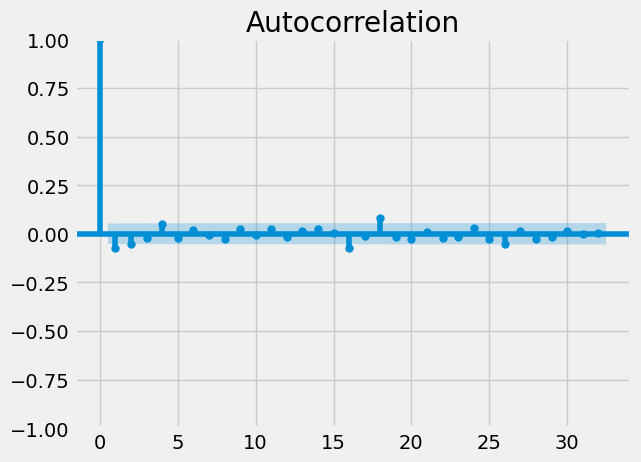

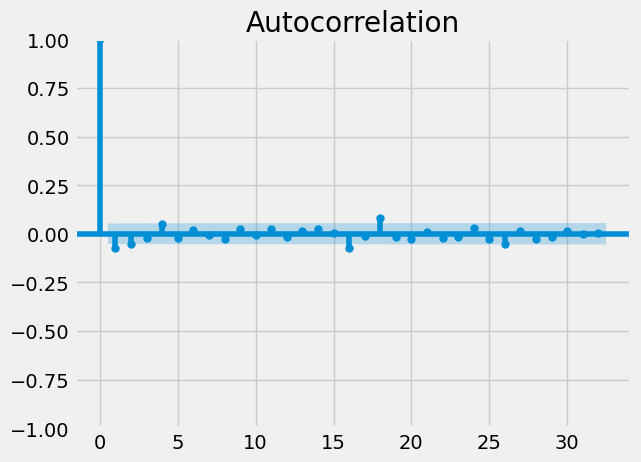

In [ ]:
Open = data_diff['Open']
plot_acf(Open)

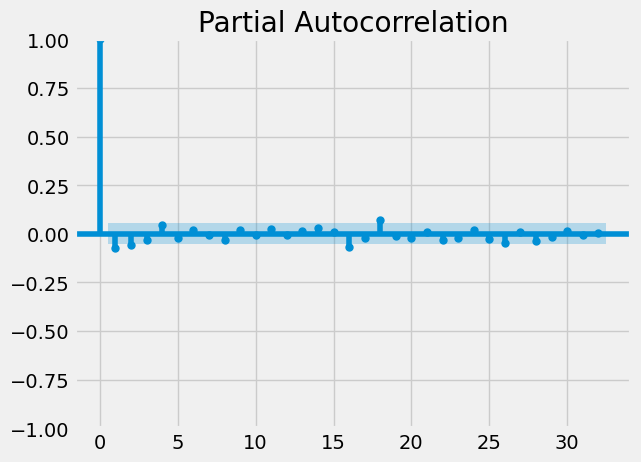

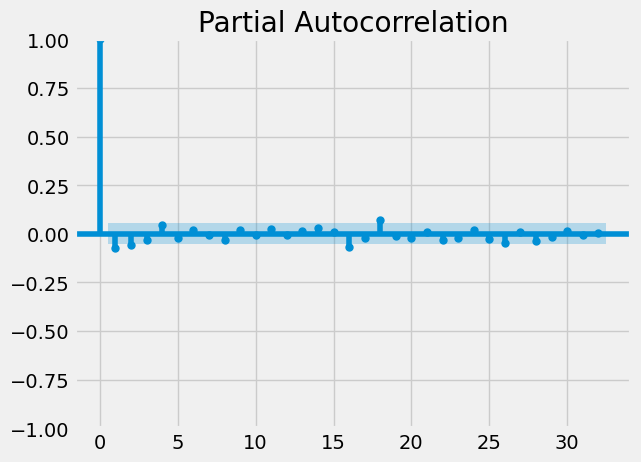

In [ ]:
plot_pacf(Open)

### **Plot ACF dan PACF High**

In [ ]:
High = data_diff['High']

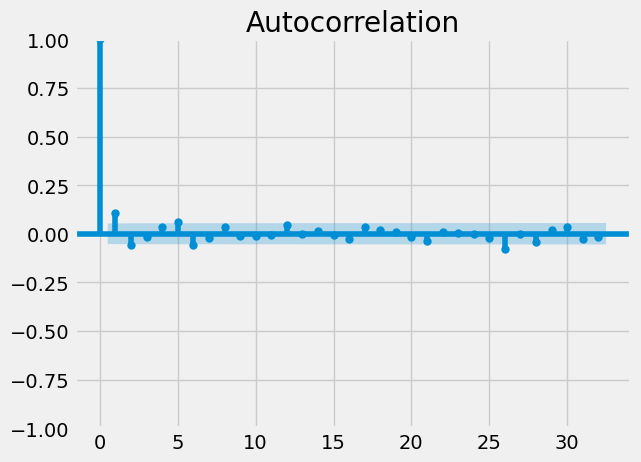

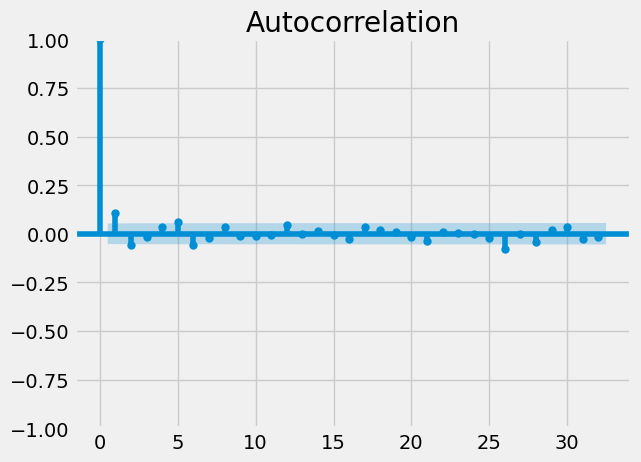

In [ ]:
plot_acf(High)

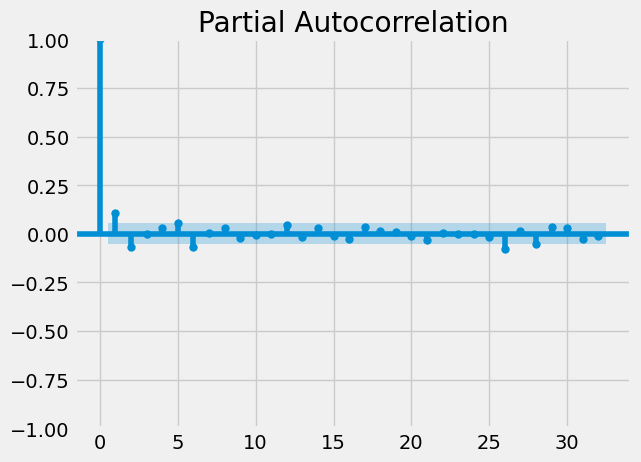

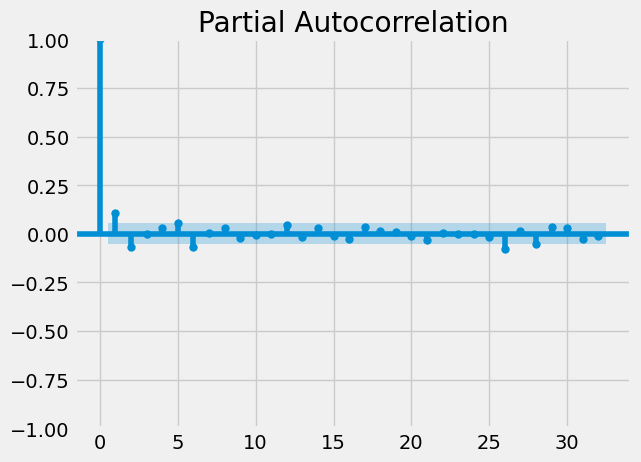

In [ ]:
plot_pacf(High)

### **Plot ACF dan PACF Low**

In [ ]:
Low = data_diff['Low']

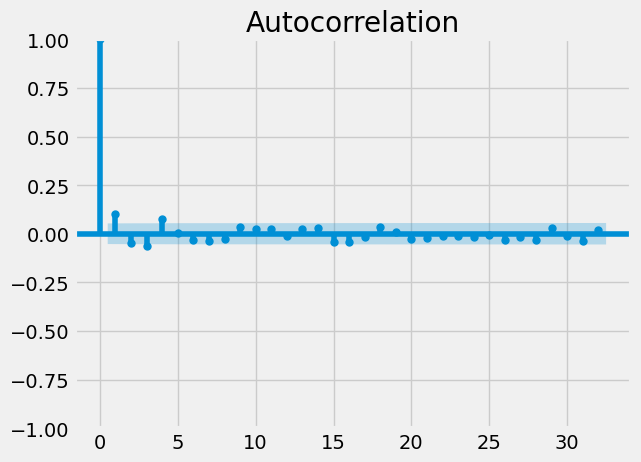

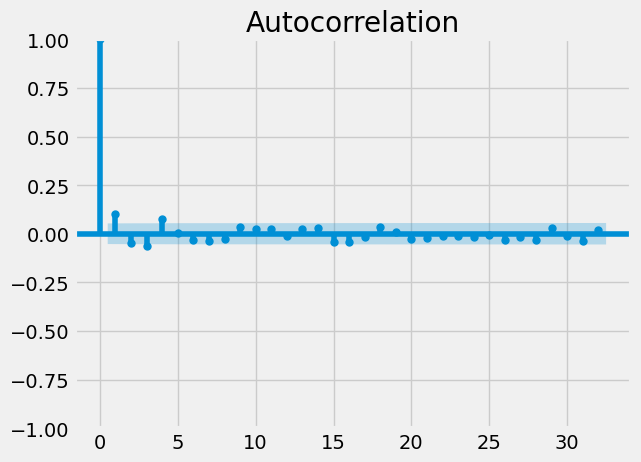

In [ ]:
plot_acf(Low)

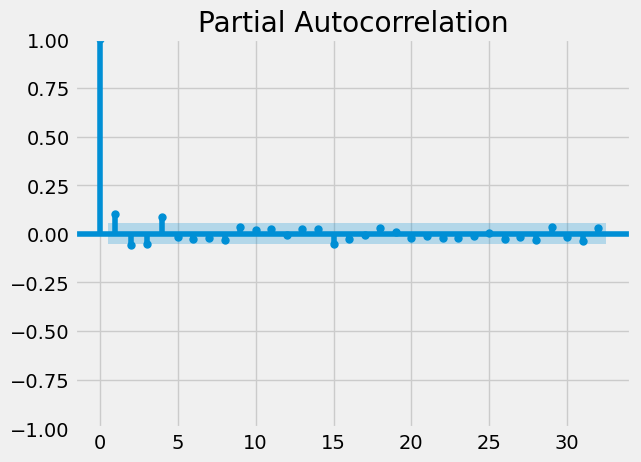

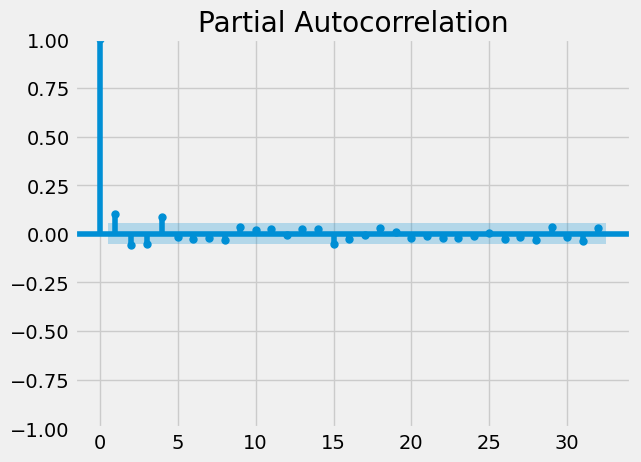

In [ ]:
plot_pacf(Low)

### **Plot ACF dan PACF Close**

In [ ]:
Close = data_diff['Close']

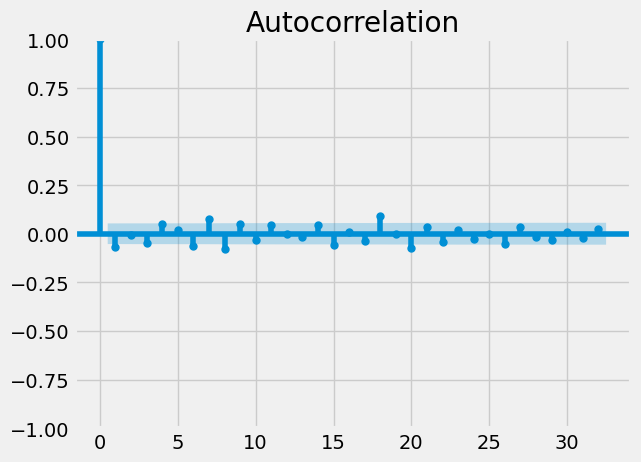

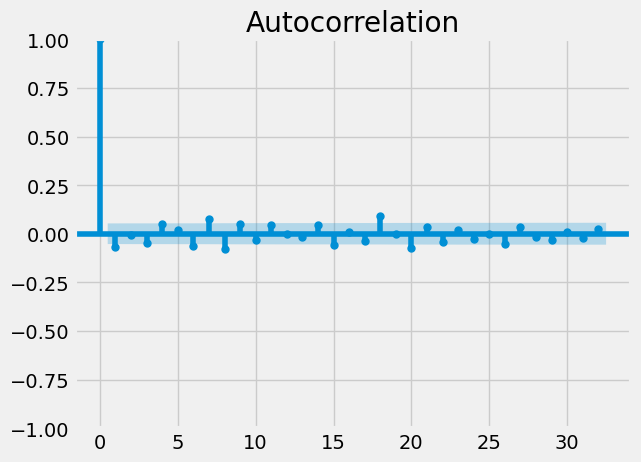

In [ ]:
plot_acf(Close)

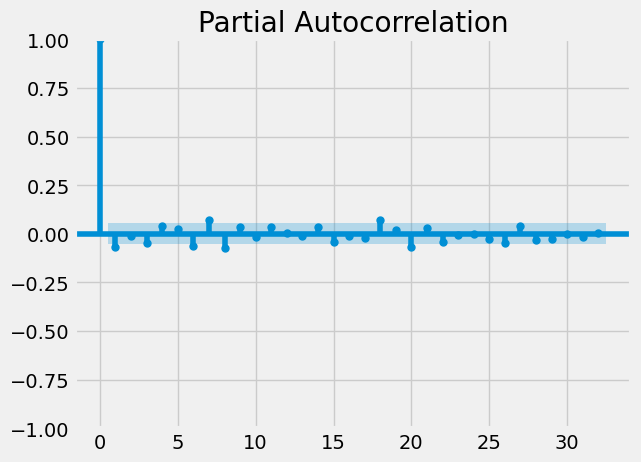

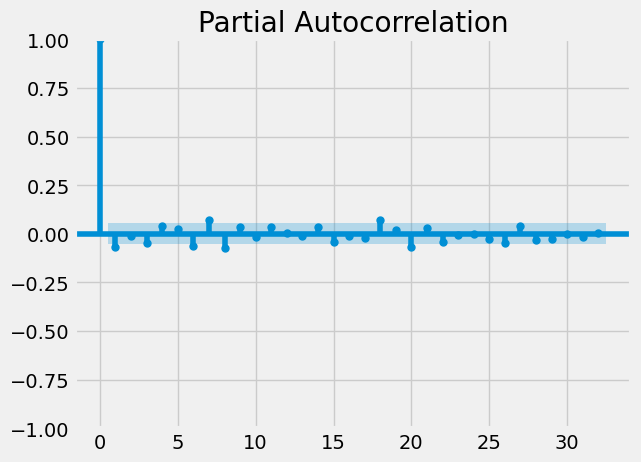

In [ ]:
plot_pacf(Close)

### **Trial and Error**

In [ ]:
%%time
model1 = VARMAX(data_diff, order = (1, 1, 1))
model1_fit = model1.fit(maxiter = 1000, disp = False)
print(model1_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(1,1)   Log Likelihood               -6901.168
                                        + intercept   AIC                          13894.337
Date:                              Mon, 19 Jun 2023   BIC                          14134.271
Time:                                      06:46:00   HQIC                         13984.156
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         6.10, 3.30, 0.00, 0.40   Jarque-Bera (JB):   5868.01, 3510.69, 12336.48, 3773.93
Prob(Q):                    0.01, 0.07, 0.98, 0.53   P

In [ ]:
%%time
model2 = VARMAX(data_diff,order = (2, 1, 1))
model2_fit = model2.fit(maxiter = 1000, disp = False)
print(model2_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(2,1)   Log Likelihood               -6863.430
                                        + intercept   AIC                          13850.860
Date:                              Mon, 19 Jun 2023   BIC                          14174.250
Time:                                      06:48:57   HQIC                         13971.921
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         4.61, 1.53, 0.49, 0.00   Jarque-Bera (JB):   5129.11, 3734.23, 10615.31, 3867.02
Prob(Q):                    0.03, 0.22, 0.49, 0.97   P

In [ ]:
%%time
model3 = VARMAX(data_diff,order = (3, 1, 1))
model3_fit = model3.fit(maxiter = 1000, disp = False)
print(model3_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(3,1)   Log Likelihood               -6863.420
                                        + intercept   AIC                          13882.840
Date:                              Mon, 19 Jun 2023   BIC                          14289.687
Time:                                      06:52:33   HQIC                         14035.143
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         2.80, 1.26, 0.01, 0.05   Jarque-Bera (JB):   4736.74, 3657.94, 7906.67, 3559.40
Prob(Q):                    0.09, 0.26, 0.91, 0.83   Pr

In [ ]:
%%time
model4 = VARMAX(data_diff,order = (4, 1, 1))
model4_fit = model4.fit(maxiter = 1000, disp = False)
print(model4_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(4,1)   Log Likelihood               -6823.283
                                        + intercept   AIC                          13834.567
Date:                              Mon, 19 Jun 2023   BIC                          14324.868
Time:                                      06:57:03   HQIC                         14018.111
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         0.37, 0.12, 0.03, 0.01   Jarque-Bera (JB):   4975.94, 3603.66, 8386.90, 3115.95
Prob(Q):                    0.54, 0.73, 0.86, 0.91   Pr

In [ ]:
%%time
model5 = VARMAX(data_diff,order = (5, 1, 1))
model5_fit = model5.fit(maxiter = 1000, disp = False)
print(model5_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(5,1)   Log Likelihood               -6817.386
                                        + intercept   AIC                          13854.772
Date:                              Mon, 19 Jun 2023   BIC                          14428.529
Time:                                      07:02:10   HQIC                         14069.558
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         0.89, 0.01, 0.01, 0.27   Jarque-Bera (JB):   4870.70, 3918.74, 8215.51, 3335.04
Prob(Q):                    0.35, 0.93, 0.92, 0.60   Pr

In [ ]:
%%time
model6 = VARMAX(data_diff,order = (6, 1, 1))
model6_fit = model6.fit(maxiter = 1000, disp = False)
print(model6_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(6,1)   Log Likelihood               -6812.405
                                        + intercept   AIC                          13876.811
Date:                              Mon, 19 Jun 2023   BIC                          14534.024
Time:                                      07:08:12   HQIC                         14122.838
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         0.37, 0.83, 0.54, 0.23   Jarque-Bera (JB):   3711.47, 3605.45, 7498.75, 2899.83
Prob(Q):                    0.54, 0.36, 0.46, 0.63   Pr

In [ ]:
%%time
model7 = VARMAX(data_diff,order = (7, 1, 1))
model7_fit = model7.fit(maxiter = 1000, disp = False)
print(model7_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(7,1)   Log Likelihood               -6776.473
                                        + intercept   AIC                          13836.946
Date:                              Mon, 19 Jun 2023   BIC                          14577.614
Time:                                      07:15:02   HQIC                         14114.214
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         0.00, 0.03, 0.00, 0.06   Jarque-Bera (JB):   3784.56, 3385.40, 6682.51, 2775.60
Prob(Q):                    0.99, 0.87, 0.95, 0.81   Pr

In [ ]:
%%time
model8 = VARMAX(data_diff,order = (8, 1, 1))
model8_fit = model8.fit(maxiter = 1000, disp = False)
print(model8_fit.summary())

                                  Statespace Model Results                                  
Dep. Variable:     ['Open', 'High', 'Low', 'Close']   No. Observations:                 1361
Model:                                   VARMA(8,1)   Log Likelihood               -6758.676
                                        + intercept   AIC                          13833.352
Date:                              Tue, 20 Jun 2023   BIC                          14657.476
Time:                                      08:49:58   HQIC                         14141.862
Sample:                                           0                                         
                                             - 1361                                         
Covariance Type:                                opg                                         
Ljung-Box (L1) (Q):         0.30, 0.19, 0.00, 0.00   Jarque-Bera (JB):   3638.43, 3357.44, 6997.13, 2623.97
Prob(Q):                    0.58, 0.66, 0.95, 0.98   Pr

###**Prediksi**

In [ ]:
prediction = pd.DataFrame(model8_fit.predict())
prediction.columns = ['Pred Open','Pred High','Pred Low','Pred Close']
prediction.index.names = ['Date']
prediction

Pred Open  Pred High  Pred Low  Pred Close
Date                                                  
2017-01-04   0.087740   0.089729  0.086629    0.088324
2017-01-05   0.086476   0.090656 -0.002146    0.162413
2017-01-06   0.173318   0.144517  0.097281    0.131888
2017-01-09   0.252930   0.126456  0.194193    0.090367
2017-01-10   0.269203   0.119271  0.148685    0.131511
...               ...        ...       ...         ...
2022-05-24   5.945891   2.491369  2.694424   -0.346265
2022-05-25  -1.721779  -0.250007 -0.774463   -1.753963
2022-05-26   2.237859   1.791658  0.621946    1.380147
2022-05-27   7.010881   2.904507  5.169810    1.659459
2022-05-31   4.580247   2.414749  2.351357    0.775058

[1361 rows x 4 columns]

### **Denormalization**

In [ ]:
prediction['Pred Open'] = data['Open'].shift(1) + prediction['Pred Open']
prediction['Pred High'] = data['High'].shift(1) + prediction['Pred High']
prediction['Pred Low'] = data['Low'].shift(1) + prediction['Pred Low']
prediction['Pred Close'] = data['Close'].shift(1) + prediction['Pred Close']
prediction

Pred Open   Pred High    Pred Low  Pred Close
Date                                                      
2017-01-04   29.037741   29.172229   28.776630   29.125824
2017-01-05   29.048976   29.218157   28.935354   29.167412
2017-01-06   29.153318   29.359517   29.049780   29.284388
2017-01-09   29.447930   29.666457   29.311693   29.567868
2017-01-10   29.756702   29.976771   29.633686   29.879010
...                ...         ...         ...         ...
2022-05-24  143.735884  145.751364  140.344418  142.763736
2022-05-25  139.088219  141.719994  136.555539  138.606038
2022-05-26  140.667852  143.581651  138.961942  141.900151
2022-05-27  144.400880  147.244503  142.309809  145.439458
2022-05-31  149.970246  152.094742  147.611352  150.415057

[1361 rows x 4 columns]

In [ ]:
data_loc = data.iloc[1:]
data_loc

Open        High         Low       Close
Date                                                      
2017-01-04   28.962500   29.127501   28.937500   29.004999
2017-01-05   28.980000   29.215000   28.952499   29.152500
2017-01-06   29.195000   29.540001   29.117500   29.477501
2017-01-09   29.487499   29.857500   29.485001   29.747499
2017-01-10   29.692499   29.844999   29.575001   29.777500
...                ...         ...         ...         ...
2022-05-24  140.809998  141.970001  137.330002  140.360001
2022-05-25  138.429993  141.789993  138.339996  140.520004
2022-05-26  137.389999  144.339996  137.139999  143.779999
2022-05-27  145.389999  149.679993  145.259995  149.639999
2022-05-31  149.070007  150.660004  146.839996  148.839996

[1361 rows x 4 columns]

### **Gabungan Prediksi dan data aktual**

In [ ]:
gabungan = pd.merge(prediction, data_loc, left_index = True, right_index = True)
gabungan

Pred Open   Pred High    Pred Low  Pred Close        Open  \
Date                                                                     
2017-01-04   29.037741   29.172229   28.776630   29.125824   28.962500   
2017-01-05   29.048976   29.218157   28.935354   29.167412   28.980000   
2017-01-06   29.153318   29.359517   29.049780   29.284388   29.195000   
2017-01-09   29.447930   29.666457   29.311693   29.567868   29.487499   
2017-01-10   29.756702   29.976771   29.633686   29.879010   29.692499   
...                ...         ...         ...         ...         ...   
2022-05-24  143.735884  145.751364  140.344418  142.763736  140.809998   
2022-05-25  139.088219  141.719994  136.555539  138.606038  138.429993   
2022-05-26  140.667852  143.581651  138.961942  141.900151  137.389999   
2022-05-27  144.400880  147.244503  142.309809  145.439458  145.389999   
2022-05-31  149.970246  152.094742  147.611352  150.415057  149.070007   

                  High         Low       Close  
Date                                            
2017-01-04   29.127501   28.937500   29.004999  
2017-01-05   29.215000   28.952499   29.152500  
2017-01-06   29.540001   29.117500   29.477501  
2017-01-09   29.857500   29.485001   29.747499  
2017-01-10   29.844999   29.575001   29.777500  
...                ...         ...         ...  
2022-05-24  141.970001  137.330002  140.360001  
2022-05-25  141.789993  138.339996  140.520004  
2022-05-26  144.339996  137.139999  143.779999  
2022-05-27  149.679993  145.259995  149.639999  
2022-05-31  150.660004  146.839996  148.839996  

[1361 rows x 8 columns]

### **Plot Data Aktual dan Prediksi**

Text(0.5, 1.0, 'Prediction using VARIMA')

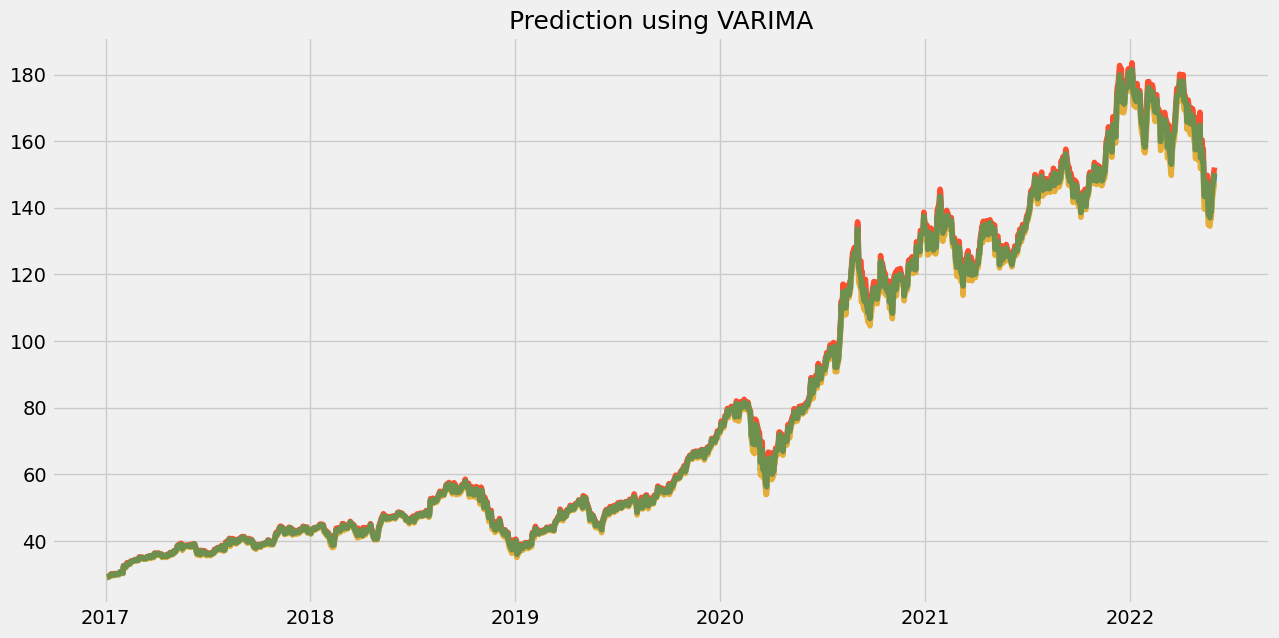

In [ ]:
plt.figure(figsize = (14,7))
plt.plot(prediction)
plt.title('Prediction using VARIMA', fontsize = 18)

Text(0.5, 1.0, ' Actual Data vs Prediction\n')

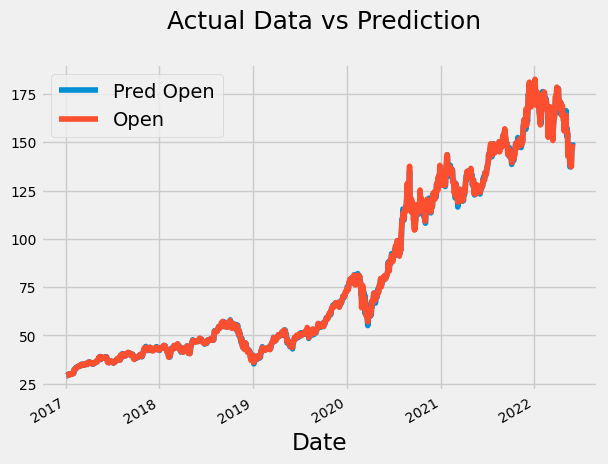

In [ ]:
prediction['Pred Open'].plot(legend = True, fontsize = 10)
data_loc['Open'].plot(legend = True, fontsize = 10)
plt.title(" Actual Data vs Prediction\n", fontsize = 18)

Text(0.5, 1.0, 'Actual Data vs Prediction\n')

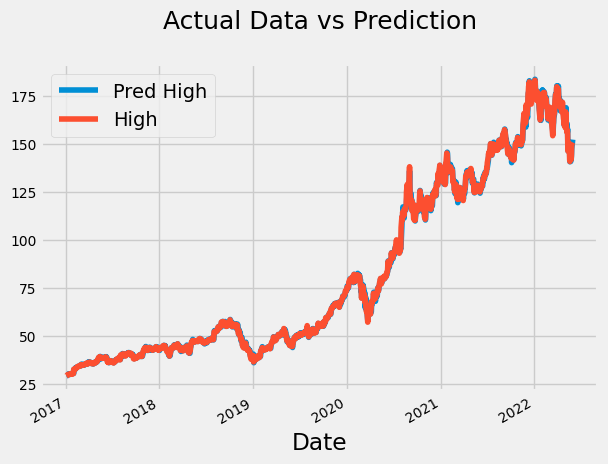

In [ ]:
prediction['Pred High'].plot(legend = True, fontsize = 10)
data_loc['High'].plot(legend = True, fontsize = 10)
plt.title("Actual Data vs Prediction\n", fontsize = 18)

Text(0.5, 1.0, 'Actual Data vs Prediction\n')

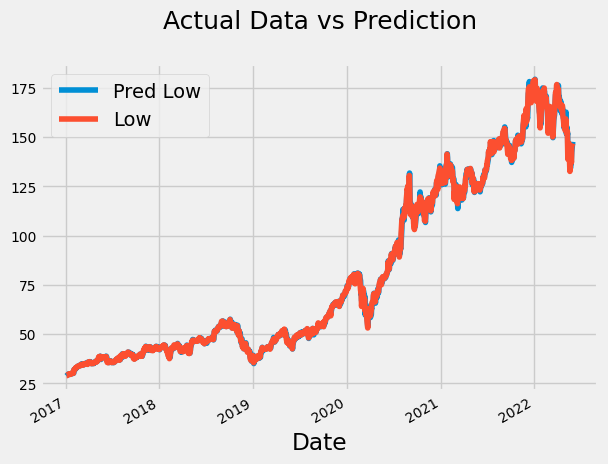

In [ ]:
prediction['Pred Low'].plot(legend = True, fontsize = 10)
data_loc['Low'].plot(legend = True, fontsize = 10)
plt.title("Actual Data vs Prediction\n", fontsize = 18)

Text(0.5, 1.0, 'Actual Data vs Prediction\n')

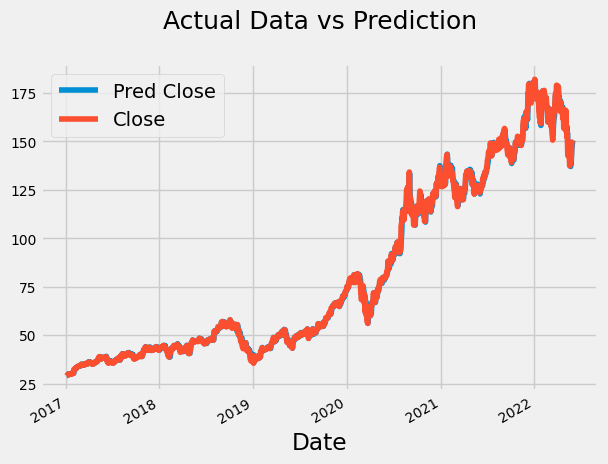

In [ ]:
prediction['Pred Close'].plot(legend = True, fontsize = 10)
data_loc['Close'].plot(legend = True, fontsize = 10)
plt.title("Actual Data vs Prediction\n", fontsize = 18)

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(data_loc, prediction)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_loc, prediction)
mae = mean_absolute_error(data_loc, prediction)
akurasi = 100 - mape
print("MSE VARIMA Model is %.2f" % mse)
print("RMSE VARIMA Model is %.2f" % rmse)
print("MAPE VARIMA Model is %.2f" % mape)
print("MAE VARIMA Model is %.2f" % mae)
print("Accuracy VARIMA Model is %.2f" % akurasi)

MSE VARIMA Model is 1.94
RMSE VARIMA Model is 1.39
MAPE VARIMA Model is 0.01
MAE VARIMA Model is 0.86
Accuracy VARIMA Model is 99.99


### **Nilai Residual**

<Axes: xlabel='Date'>

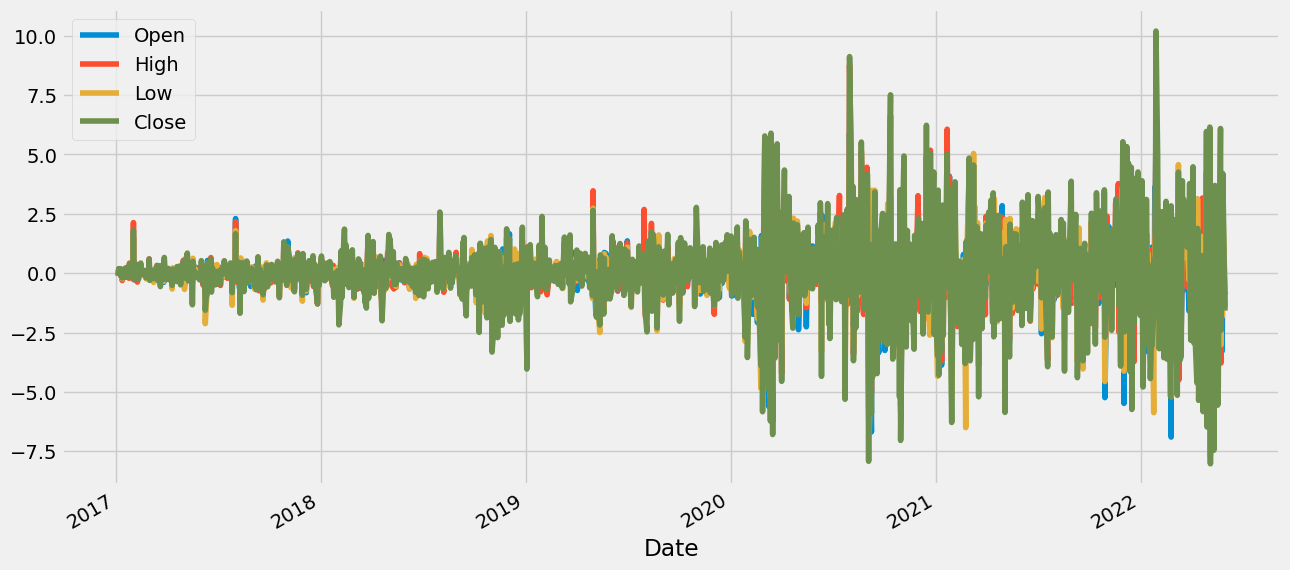

In [ ]:
residual = pd.DataFrame(model8_fit.resid)
residual.plot(figsize = (14,7))

In [ ]:
residual

Open      High       Low     Close
Date                                              
2017-01-04 -0.075241 -0.044728  0.160870 -0.120825
2017-01-05 -0.068976 -0.003157  0.017145 -0.014912
2017-01-06  0.041682  0.180484  0.067720  0.193113
2017-01-09  0.039569  0.191043  0.173308  0.179631
2017-01-10 -0.064203 -0.131772 -0.058685 -0.101510
...              ...       ...       ...       ...
2022-05-24 -2.925886 -3.781363 -3.014416 -2.403735
2022-05-25 -0.658226  0.069999  1.784457  1.913966
2022-05-26 -3.277853  0.758345 -1.821943  1.879848
2022-05-27  0.989119  2.435490  2.950186  4.200541
2022-05-31 -0.900239 -1.434738 -0.771356 -1.575061

[1361 rows x 4 columns]

## **LSTM**

### **Model 1 LSTM input Prediksi VARIMA**

In [ ]:
prediction

Pred Open   Pred High    Pred Low  Pred Close
Date                                                      
2017-01-04   29.037741   29.172229   28.776630   29.125824
2017-01-05   29.048976   29.218157   28.935354   29.167412
2017-01-06   29.153318   29.359517   29.049780   29.284388
2017-01-09   29.447930   29.666457   29.311693   29.567868
2017-01-10   29.756702   29.976771   29.633686   29.879010
...                ...         ...         ...         ...
2022-05-24  143.735884  145.751364  140.344418  142.763736
2022-05-25  139.088219  141.719994  136.555539  138.606038
2022-05-26  140.667852  143.581651  138.961942  141.900151
2022-05-27  144.400880  147.244503  142.309809  145.439458
2022-05-31  149.970246  152.094742  147.611352  150.415057

[1361 rows x 4 columns]

In [ ]:
prediction.shape

(1361, 4)

### **Splitting Data 80:20**

In [ ]:
training_portion = .8

#train size
train_size = int(len(prediction) * training_portion)

training_data_predict = prediction[0: train_size]
testing_data_predict = prediction[train_size:]

print("train_data: ", training_data_predict.shape)
print("test_data: ", testing_data_predict.shape)

train_data:  (1088, 4)
test_data:  (273, 4)


### **Scaling Data Prediksi**

In [ ]:
# MinMax Scaler
scaler = MinMaxScaler()

# Data Train
train_predict_scale = pd.DataFrame(scaler.fit_transform(training_data_predict), columns = ['Open', 'High', 'Low', 'Close'])
test_predict_scale = pd.DataFrame(scaler.fit_transform(testing_data_predict), columns = ['Open', 'High', 'Low', 'Close'])

In [ ]:
train_data_prediction = np.array(train_predict_scale)
test_data_prediction = np.array(test_predict_scale)

In [ ]:
def create_dataset(dataset,time_steps):
    dataX = []
    dataY = []
    for i in range(time_steps, len(dataset)):
            dataX.append(dataset[i - time_steps:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0:dataset.shape[1]])
    return np.array(dataX),np.array(dataY)

In [ ]:
time_steps = 5
X_train_prediction, y_train_prediction = create_dataset(train_data_prediction, time_steps)
X_test_prediction, y_test_prediction = create_dataset(test_data_prediction, time_steps)

### **Hypertuning menggunakan Grid Search**

In [ ]:
def create_model(LSTM_unit, dropout):
  # create model
  model = Sequential()
  model.add(LSTM(units = LSTM_unit, input_shape = (time_steps, 4), activation = 'tanh' ))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(4, activation = 'sigmoid'))

  # compile model
  model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.0001))

  return model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#create model
model = KerasRegressor(build_fn = create_model, validation_split = 0.25, callbacks = [es], epochs = 100, verbose = 1)
LSTM_unit = [16, 32, 64]
batch_size = [16, 32, 64]
dropout = [0.1]
param_grid = dict(batch_size = batch_size, LSTM_unit = LSTM_unit, dropout = dropout)

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 3, cv = 5, verbose = 1)

In [ ]:
%%time
grid_result_prediction = grid.fit(X_train_prediction, y_train_prediction, validation_split = 0.25, verbose = 1, callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/100
51/51 [==============================] - 5s 22ms/step - loss: 0.1683 - val_loss: 0.0910
Epoch 2/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1428 - val_loss: 0.0874
Epoch 3/100
51/51 [==============================] - 0s 10ms/step - loss: 0.1338 - val_loss: 0.0825
Epoch 4/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1258 - val_loss: 0.0762
Epoch 5/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1215 - val_loss: 0.0654
Epoch 6/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1181 - val_loss: 0.0505
Epoch 7/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1134 - val_loss: 0.0349
Epoch 8/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1123 - val_loss: 0.0237
Epoch 9/100
51/51 [==============================] - 0s 9ms/step - loss: 0.1086 - val_loss: 0.0165
Epoch 10/100
51/51 [===========================

In [ ]:
# melihat hasil parameter terbaik
print("Best: %f using %s" % (grid_result_prediction.best_score_, grid_result_prediction.best_params_))
means = grid_result_prediction.cv_results_['mean_test_score']
stds = grid_result_prediction.cv_results_['std_test_score']
params = grid_result_prediction.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

# mengambil model terbaik
best_model_prediction = grid_result_prediction.best_estimator_.model

Best: -0.032722 using {'LSTM_unit': 32, 'batch_size': 16, 'dropout': 0.1}
-0.041090 (0.012536) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.1}
-0.055853 (0.027779) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.1}
-0.070408 (0.041805) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.1}
-0.032722 (0.003265) with: {'LSTM_unit': 32, 'batch_size': 16, 'dropout': 0.1}
-0.076150 (0.056263) with: {'LSTM_unit': 32, 'batch_size': 32, 'dropout': 0.1}
-0.068066 (0.041206) with: {'LSTM_unit': 32, 'batch_size': 64, 'dropout': 0.1}
-0.034166 (0.021989) with: {'LSTM_unit': 64, 'batch_size': 16, 'dropout': 0.1}
-0.056967 (0.025502) with: {'LSTM_unit': 64, 'batch_size': 32, 'dropout': 0.1}
-0.058211 (0.038518) with: {'LSTM_unit': 64, 'batch_size': 64, 'dropout': 0.1}


### **Membangun Model LSTM untuk Data Prediksi**

In [ ]:
seed = 123
np.random.seed(seed)

In [ ]:
# Build model
model_prediction = Sequential()
model_prediction.add(LSTM(units = 16, input_shape = (time_steps, 4), activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))
model_prediction.add(Dense(units = 32, activation = 'tanh'))
model_prediction.add(Dense(units = 16, activation = 'tanh'))
model_prediction.add(Dense(units = 8, activation = 'tanh'))
model_prediction.add(Dense(4, activation = 'sigmoid'))

# Compile model
model_prediction.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
%%time
#Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#Fit Model
history_prediction = model_prediction.fit(X_train_prediction, y_train_prediction, epochs = 100, batch_size = 16, verbose = 1, validation_data = (X_test_prediction, y_test_prediction), callbacks = [es])

Epoch 1/100
68/68 [==============================] - 3s 13ms/step - loss: 0.0690 - val_loss: 0.0097
Epoch 2/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0050 - val_loss: 0.0096
Epoch 3/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0072
Epoch 4/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0065
Epoch 5/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 6/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 7/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0059
Epoch 8/100
68/68 [==============================] - 0s 6ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 9/100
68/68 [==============================] - 0s 5ms/step - loss: 0.0014 - val_loss: 0.0049
Epoch 10/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0049
Epoch 11

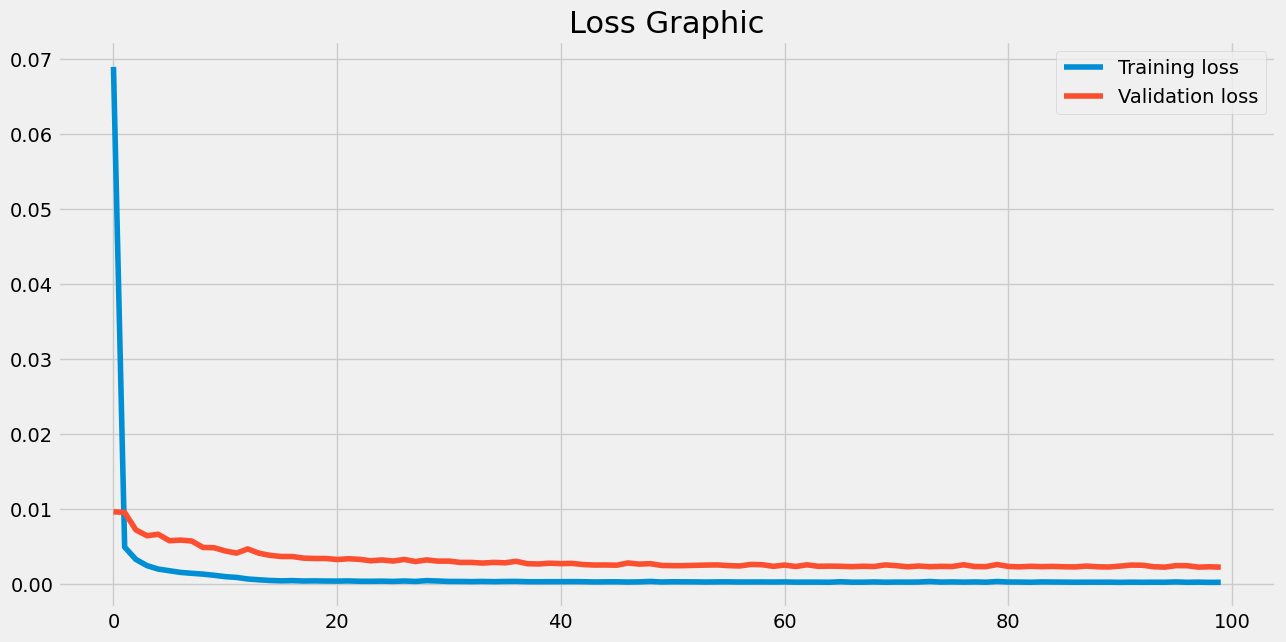

In [ ]:
plt.figure(figsize = (14, 7))
plt.plot(history_prediction.history['loss'], label = 'Training loss')
plt.plot(history_prediction.history['val_loss'], label = 'Validation loss')
plt.title('Loss Graphic', fontsize = 22)
plt.legend()

In [ ]:
test_predict1 = model_prediction.predict(X_test_prediction)
test_predict1

9/9 [==============================] - 0s 2ms/step


array([[0.12000164, 0.11967195, 0.12037578, 0.11952484],
       [0.12075322, 0.12056752, 0.12123677, 0.12047123],
       [0.09731405, 0.09740189, 0.0981006 , 0.09726934],
       ...,
       [0.28868237, 0.29125002, 0.29059845, 0.29053813],
       [0.31707498, 0.3195744 , 0.31950462, 0.3193798 ],
       [0.37223276, 0.37531278, 0.3754683 , 0.37547565]], dtype=float32)

In [ ]:
test_data_prediction = np.array(testing_data_predict.iloc[5:])
test_data_prediction = pd.DataFrame(test_data_prediction, columns = ['Open', 'High', 'Low', 'Close'])
test_data_prediction

Open        High         Low       Close
0    130.320098  131.509612  128.735938  129.898919
1    126.814504  128.413108  125.680071  127.081350
2    126.316020  127.442552  124.733153  126.296451
3    122.723425  124.388891  121.953194  122.907698
4    125.185597  126.822288  124.646208  125.922006
..          ...         ...         ...         ...
263  143.735884  145.751364  140.344418  142.763736
264  139.088219  141.719994  136.555539  138.606038
265  140.667852  143.581651  138.961942  141.900151
266  144.400880  147.244503  142.309809  145.439458
267  149.970246  152.094742  147.611352  150.415057

[268 rows x 4 columns]

In [ ]:
test_model_prediction = scaler.inverse_transform(test_predict1)
test_model_prediction

array([[129.77809, 131.31644, 128.86421, 129.90459],
       [129.82227, 131.36949, 128.91365, 129.96005],
       [128.44432, 129.99677, 127.58534, 128.60028],
       ...,
       [139.69447, 141.48376, 138.63704, 139.927  ],
       [141.36362, 143.1622 , 140.2966 , 141.61731],
       [144.60625, 146.46513, 143.50958, 144.90486]], dtype=float32)

In [ ]:
test_model_prediction = pd.DataFrame(test_model_prediction, columns = ['Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Close'])
test_model_prediction

Prediction Open  Prediction High  Prediction Low  Prediction Close
0         129.778091       131.316437      128.864212        129.904587
1         129.822266       131.369492      128.913651        129.960052
2         128.444321       129.996765      127.585342        128.600281
3         127.744118       129.288071      126.896080        127.893173
4         126.472839       128.023941      125.660591        126.635483
..               ...              ...             ...               ...
263       137.120804       138.881821      136.080933        137.296494
264       141.641525       143.447388      140.519501        141.854446
265       139.694473       141.483765      138.637039        139.927002
266       141.363617       143.162201      140.296600        141.617310
267       144.606247       146.465134      143.509583        144.904861

[268 rows x 4 columns]

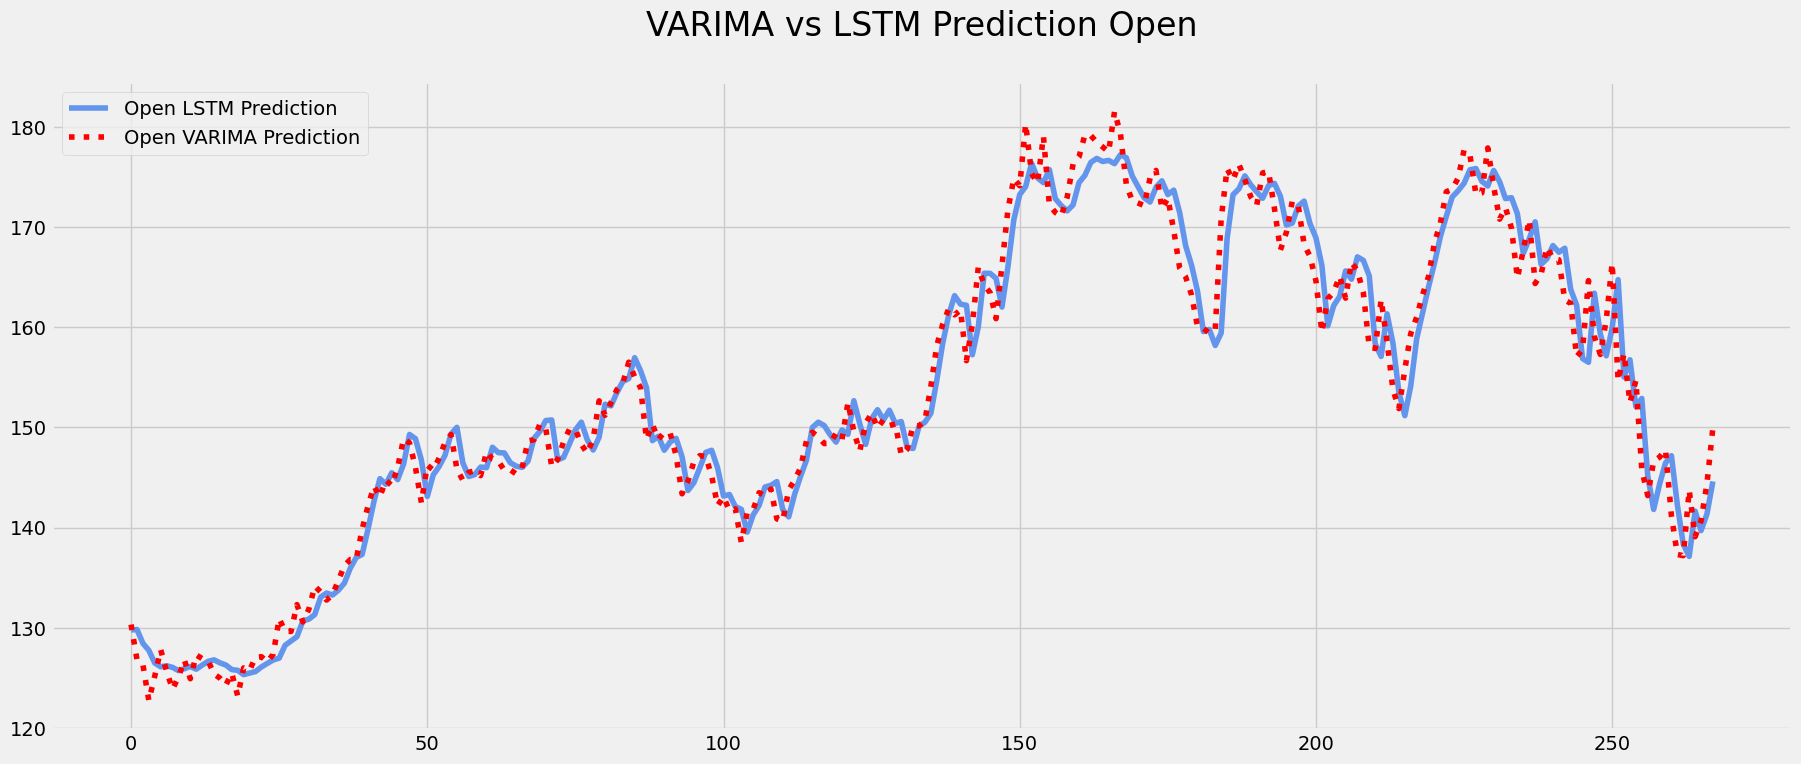

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Open'], label = ('Open LSTM Prediction'), color='cornflowerblue')
plt.plot(test_data_prediction['Open'], label = ('Open VARIMA Prediction'), linestyle = 'dotted', color='red')
plt.title('VARIMA vs LSTM Prediction Open\n', fontsize = 24)
plt.legend()
plt.show()

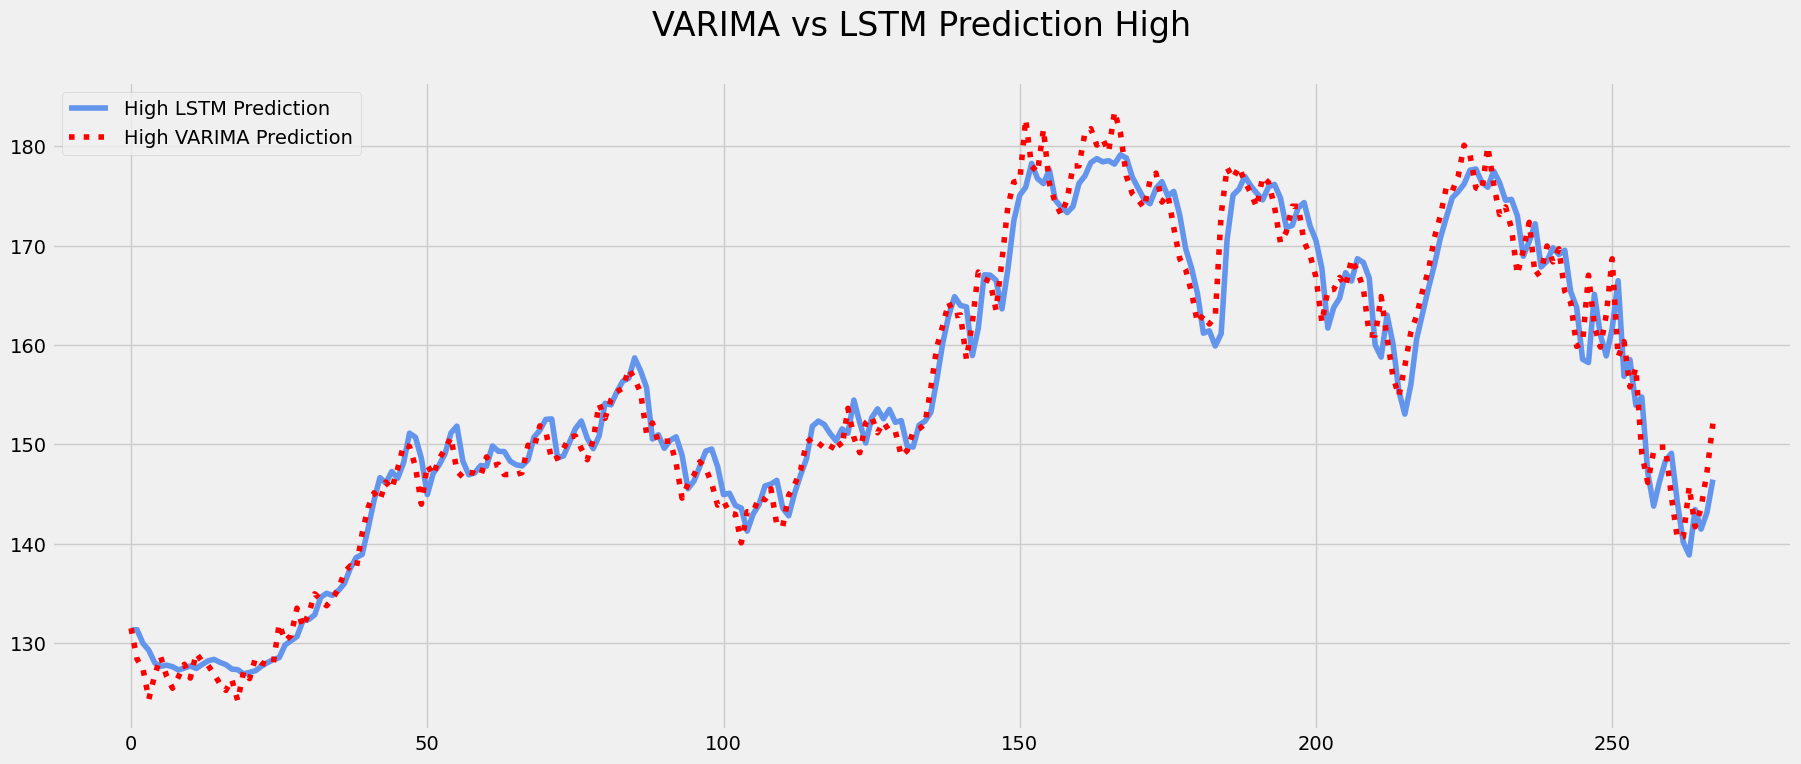

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction High'], label = ('High LSTM Prediction'), color = 'cornflowerblue')
plt.plot(test_data_prediction['High'], label = ('High VARIMA Prediction'), linestyle = 'dotted', color = 'red')
plt.title('VARIMA vs LSTM Prediction High\n', fontsize = 24)
plt.legend()
plt.show()

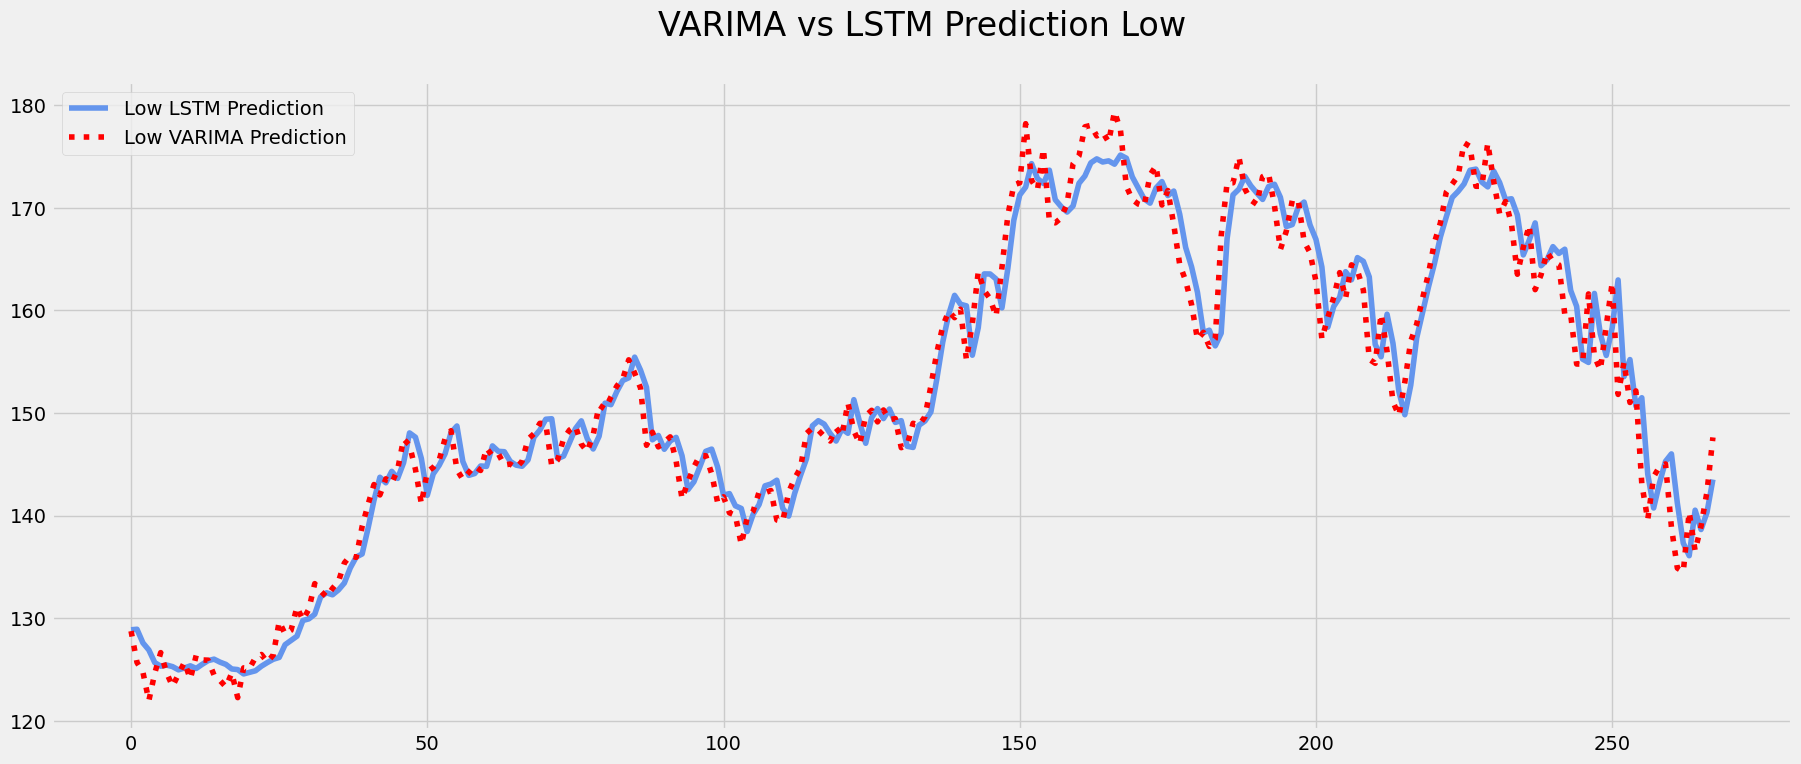

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Low'], label = ('Low LSTM Prediction'), color='cornflowerblue')
plt.plot(test_data_prediction['Low'], label = ('Low VARIMA Prediction'), linestyle = 'dotted', color='red')
plt.title('VARIMA vs LSTM Prediction Low\n', fontsize = 24)
plt.legend()
plt.show()

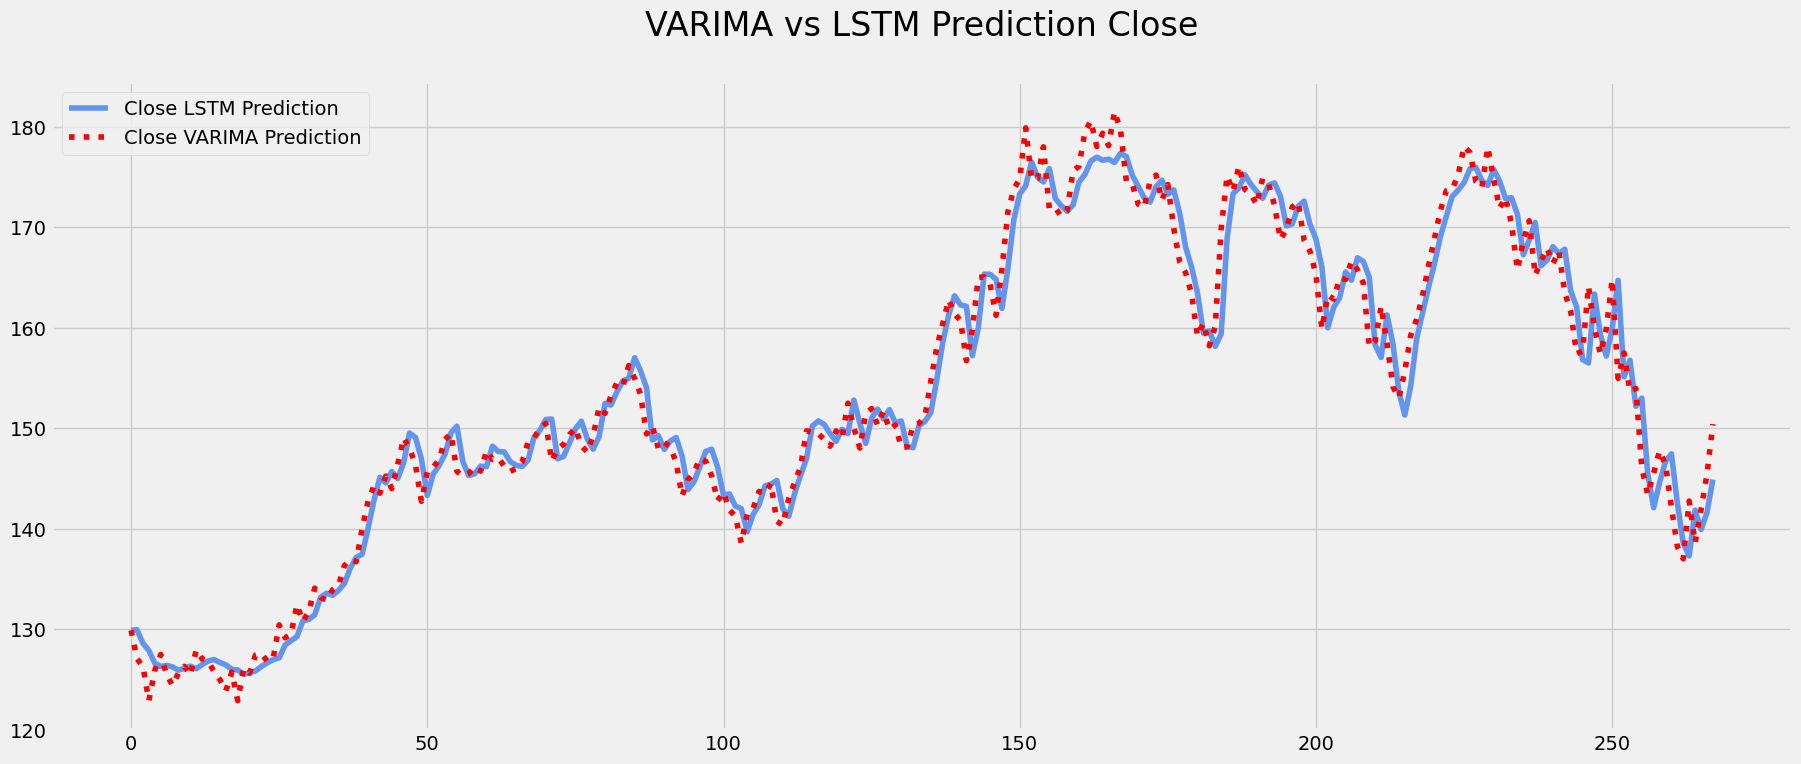

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Close'], label = ('Close LSTM Prediction'), color='cornflowerblue')
plt.plot(test_data_prediction['Close'], label = ('Close VARIMA Prediction'), linestyle = 'dotted', color='red')
plt.title('VARIMA vs LSTM Prediction Close\n', fontsize = 24)
plt.legend()
plt.show()

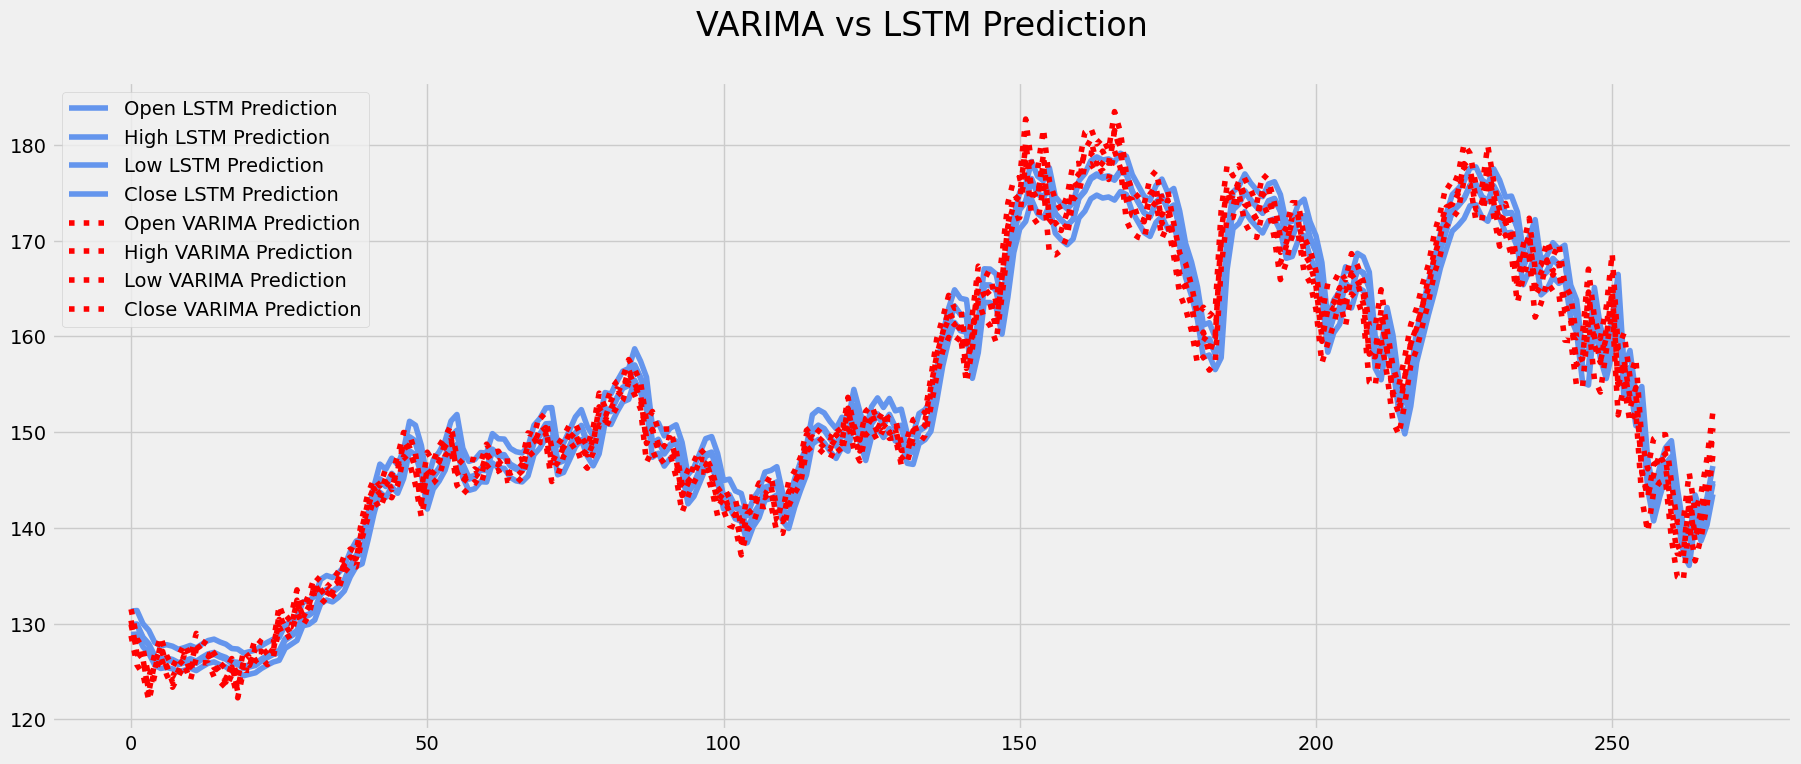

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction, label=('Open LSTM Prediction', 'High LSTM Prediction','Low LSTM Prediction', 'Close LSTM Prediction'), color= 'cornflowerblue')
plt.plot(test_data_prediction, label=('Open VARIMA Prediction', 'High VARIMA Prediction','Low VARIMA Prediction', 'Close VARIMA Prediction'), linestyle = 'dotted', color = 'red')
plt.title('VARIMA vs LSTM Prediction\n', fontsize = 24)
plt.legend()
plt.show()

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(test_data_prediction, test_model_prediction)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(test_data_prediction, test_model_prediction)
mae = mean_absolute_error(test_data_prediction, test_model_prediction)
akurasi = 100 - mape
print("MSE LSTM model1  is %.2f" % mse)
print("RMSE LSTM model1 is %.2f" % rmse)
print("MAPE LSTM model1 is %.2f" % mape)
print("MAE LSTM model1 is %.2f" % mae)
print("Accuracy LSTM model1 is %.2f" % akurasi)

MSE LSTM model1  is 7.79
RMSE LSTM model1 is 2.79
MAPE LSTM model1 is 0.01
MAE LSTM model1 is 2.14
Accuracy LSTM model1 is 99.99


### **Peramalan Data Prediksi**

In [ ]:
prediction_scale = pd.DataFrame(scaler.fit_transform(prediction), columns = ['Open', 'High', 'Low', 'Close'])
prediction_scale

Open      High       Low     Close
0     0.000000  0.000000  0.000000  0.000000
1     0.000074  0.000298  0.001054  0.000273
2     0.000758  0.001214  0.001814  0.001041
3     0.002690  0.003203  0.003553  0.002901
4     0.004715  0.005214  0.005691  0.004943
...        ...       ...       ...       ...
1356  0.752249  0.755484  0.740878  0.745754
1357  0.721767  0.729359  0.715718  0.718469
1358  0.732127  0.741424  0.731698  0.740086
1359  0.756610  0.765160  0.753930  0.763313
1360  0.793137  0.796592  0.789135  0.795966

[1361 rows x 4 columns]

In [ ]:
time_steps = 30
input_prediction = prediction_scale.tail(time_steps)
input_prediction

Open      High       Low     Close
1331  0.893467  0.895969  0.894436  0.902564
1332  0.911308  0.912376  0.909058  0.910785
1333  0.903714  0.902009  0.903077  0.900858
1334  0.903006  0.910561  0.900848  0.908886
1335  0.876645  0.882785  0.868800  0.881683
1336  0.874503  0.875466  0.868483  0.869609
1337  0.839547  0.846952  0.836633  0.841965
1338  0.844238  0.849449  0.836601  0.843566
1339  0.889367  0.893376  0.881988  0.885968
1340  0.852786  0.860540  0.841671  0.858932
1341  0.841053  0.846474  0.832771  0.841901
1342  0.863793  0.867485  0.861397  0.857988
1343  0.900856  0.904045  0.889170  0.890363
1344  0.823835  0.840036  0.816952  0.825804
1345  0.841597  0.850075  0.837842  0.842444
1346  0.809508  0.820511  0.811726  0.817274
1347  0.823973  0.832900  0.819239  0.819227
1348  0.765712  0.777029  0.759074  0.767326
1349  0.748644  0.758187  0.735793  0.750027
1350  0.771203  0.778624  0.763712  0.763923
1351  0.773866  0.781206  0.770215  0.778556
1352  0.778705  0.781327  0.771960  0.769486
1353  0.735460  0.748992  0.731081  0.741764
1354  0.710143  0.721942  0.704541  0.715948
1355  0.709367  0.722730  0.702151  0.708029
1356  0.752249  0.755484  0.740878  0.745754
1357  0.721767  0.729359  0.715718  0.718469
1358  0.732127  0.741424  0.731698  0.740086
1359  0.756610  0.765160  0.753930  0.763313
1360  0.793137  0.796592  0.789135  0.795966

In [ ]:
x_input_prediction = np.array(input_prediction).reshape(1,-1)
x_input_prediction = x_input_prediction.reshape((time_steps, 1, 4))
x_input_prediction

array([[[0.8934667 , 0.89596932, 0.89443626, 0.90256443]],

       [[0.91130835, 0.91237575, 0.90905798, 0.91078487]],

       [[0.90371392, 0.90200942, 0.90307675, 0.90085795]],

       [[0.9030057 , 0.91056087, 0.90084761, 0.90888619]],

       [[0.87664488, 0.88278539, 0.86880044, 0.88168261]],

       [[0.8745033 , 0.87546637, 0.86848277, 0.86960851]],

       [[0.83954665, 0.84695212, 0.8366334 , 0.84196503]],

       [[0.84423802, 0.84944895, 0.83660105, 0.84356639]],

       [[0.88936708, 0.89337604, 0.88198843, 0.88596813]],

       [[0.85278638, 0.86053971, 0.84167054, 0.85893203]],

       [[0.84105302, 0.8464743 , 0.83277082, 0.84190068]],

       [[0.86379294, 0.86748455, 0.86139723, 0.8579878 ]],

       [[0.90085622, 0.90404504, 0.88916958, 0.89036292]],

       [[0.82383489, 0.84003611, 0.81695233, 0.82580423]],

       [[0.84159709, 0.85007518, 0.83784244, 0.84244352]],

       [[0.80950768, 0.82051061, 0.81172551, 0.81727434]],

       [[0.82397328, 0.83290041, 0.81923

In [ ]:
daily_input_prediction = list(x_input_prediction)
daily_input_prediction = daily_input_prediction[0].tolist()
daily_input_prediction

[[0.8934667038420798,
  0.8959693211203541,
  0.8944362618349547,
  0.9025644286838621]]

In [ ]:
yhat_prediction = model_prediction.predict(x_input_prediction)
yhat_prediction

1/1 [==============================] - 0s 335ms/step


array([[0.81410664, 0.81898946, 0.81843793, 0.8227185 ],
       [0.82250905, 0.8273019 , 0.8266275 , 0.83094233],
       [0.8173575 , 0.8222004 , 0.8215342 , 0.82585835],
       [0.81857634, 0.82347846, 0.82284003, 0.82714725],
       [0.79847336, 0.80367434, 0.8031215 , 0.8074272 ],
       [0.7944743 , 0.7997036 , 0.7990737 , 0.80341446],
       [0.76977485, 0.7753558 , 0.7748291 , 0.7791077 ],
       [0.7712847 , 0.7768528 , 0.77631116, 0.78060305],
       [0.8052991 , 0.8104157 , 0.8097505 , 0.81409717],
       [0.77946234, 0.7849428 , 0.7844625 , 0.78873837],
       [0.76896626, 0.7745592 , 0.7740462 , 0.7783233 ],
       [0.7868392 , 0.79219747, 0.7915417 , 0.79588974],
       [0.81017077, 0.8152541 , 0.8145054 , 0.8188831 ],
       [0.7543226 , 0.76024234, 0.7596671 , 0.7639368 ],
       [0.77060056, 0.7762006 , 0.77564   , 0.77993417],
       [0.7470291 , 0.7528674 , 0.75242853, 0.75661576],
       [0.7530752 , 0.7589262 , 0.7583144 , 0.76259875],
       [0.6988495 , 0.70524734,

In [ ]:
# Peramalan
from numpy import array

output_peramalan_prediction = []
time_steps = 30
i = 0

#print(daily_input)
print("{} daily input {}".format(i, daily_input_prediction))

#print(x_input)
print("{} daily output {}".format(i, yhat_prediction))
daily_input_prediction.extend(yhat_prediction.tolist())
daily_input_prediction = daily_input_prediction[1:]

#print(daily_input)
output_peramalan_prediction.extend(yhat_prediction.tolist())
i = i+1

print(output_peramalan_prediction)

0 daily input [[0.8934667038420798, 0.8959693211203541, 0.8944362618349547, 0.9025644286838621]]
0 daily output [[0.81410664 0.81898946 0.81843793 0.8227185 ]
 [0.82250905 0.8273019  0.8266275  0.83094233]
 [0.8173575  0.8222004  0.8215342  0.82585835]
 [0.81857634 0.82347846 0.82284003 0.82714725]
 [0.79847336 0.80367434 0.8031215  0.8074272 ]
 [0.7944743  0.7997036  0.7990737  0.80341446]
 [0.76977485 0.7753558  0.7748291  0.7791077 ]
 [0.7712847  0.7768528  0.77631116 0.78060305]
 [0.8052991  0.8104157  0.8097505  0.81409717]
 [0.77946234 0.7849428  0.7844625  0.78873837]
 [0.76896626 0.7745592  0.7740462  0.7783233 ]
 [0.7868392  0.79219747 0.7915417  0.79588974]
 [0.81017077 0.8152541  0.8145054  0.8188831 ]
 [0.7543226  0.76024234 0.7596671  0.7639368 ]
 [0.77060056 0.7762006  0.77564    0.77993417]
 [0.7470291  0.7528674  0.75242853 0.75661576]
 [0.7530752  0.7589262  0.7583144  0.76259875]
 [0.6988495  0.70524734 0.7047957  0.7088082 ]
 [0.6784369  0.68500394 0.68460387 0.68849

In [ ]:
len(prediction)

1361

In [ ]:
len(test_model_prediction)

268

In [ ]:
output_forecast_prediction = scaler.inverse_transform(output_peramalan_prediction)
output_forecast_prediction = np.array(output_forecast_prediction)
output_forecast_prediction = pd.DataFrame(output_forecast_prediction, columns = ['Forecast Open', 'Forecast High', 'Forecast Low', 'Forecast Close'])
output_forecast_prediction

Forecast Open  Forecast High  Forecast Low  Forecast Close
0      153.167559     155.550883    152.024040      154.491643
1      154.448705     156.833583    153.257294      155.744790
2      153.663226     156.046368    152.490305      154.970094
3      153.849070     156.243583    152.686946      155.166495
4      150.783895     153.187600    149.717561      152.161559
5      150.174145     152.574873    149.108007      151.550094
6      146.408129     148.817755    145.457046      147.846229
7      146.638341     149.048753    145.680229      148.074092
8      151.824642     154.227860    150.715811      153.177924
9      147.885215     150.297128    146.907729      149.313751
10     146.284840     148.694829    145.339149      147.726702
11     149.009991     151.416598    147.973774      150.403476
12     152.567442     154.974477    151.431845      153.907208
13     144.052066     146.485588    143.173823      145.534492
14     146.534027     148.948113    145.579162      147.972167
15     142.940005     145.347557    142.083778      144.418909
16     143.861869     146.282495    142.970118      145.330598
17     135.593881     137.999283    134.910820      137.133992
18     132.481494     134.875513    131.870158      134.038095
19     135.861409     138.268037    135.154404      137.390602
20     137.279094     139.672330    136.556493      138.801358
21     136.997026     139.395095    136.256549      138.510526
22     131.095353     133.482129    130.513056      132.653568
23     126.642865     129.003163    126.143243      128.202200
24     125.854959     128.227923    125.358885      127.415823
25     132.691011     135.076021    132.052510      134.230127
26     128.034858     130.402912    127.488308      129.582921
27     130.942027     133.309471    130.355935      132.488175
28     134.749020     137.133925    134.085111      136.285337
29     140.072752     142.465234    139.279691      141.569912

In [ ]:
prediction

Pred Open   Pred High    Pred Low  Pred Close
Date                                                      
2017-01-04   29.037741   29.172229   28.776630   29.125824
2017-01-05   29.048976   29.218157   28.935354   29.167412
2017-01-06   29.153318   29.359517   29.049780   29.284388
2017-01-09   29.447930   29.666457   29.311693   29.567868
2017-01-10   29.756702   29.976771   29.633686   29.879010
...                ...         ...         ...         ...
2022-05-24  143.735884  145.751364  140.344418  142.763736
2022-05-25  139.088219  141.719994  136.555539  138.606038
2022-05-26  140.667852  143.581651  138.961942  141.900151
2022-05-27  144.400880  147.244503  142.309809  145.439458
2022-05-31  149.970246  152.094742  147.611352  150.415057

[1361 rows x 4 columns]

In [ ]:
week_forecast = np.arange(1361,1361+30)
week_predict = np.arange(1100, 1361)

Text(0.5, 1.0, 'Forecasting Model LSTM for Prediction\n')

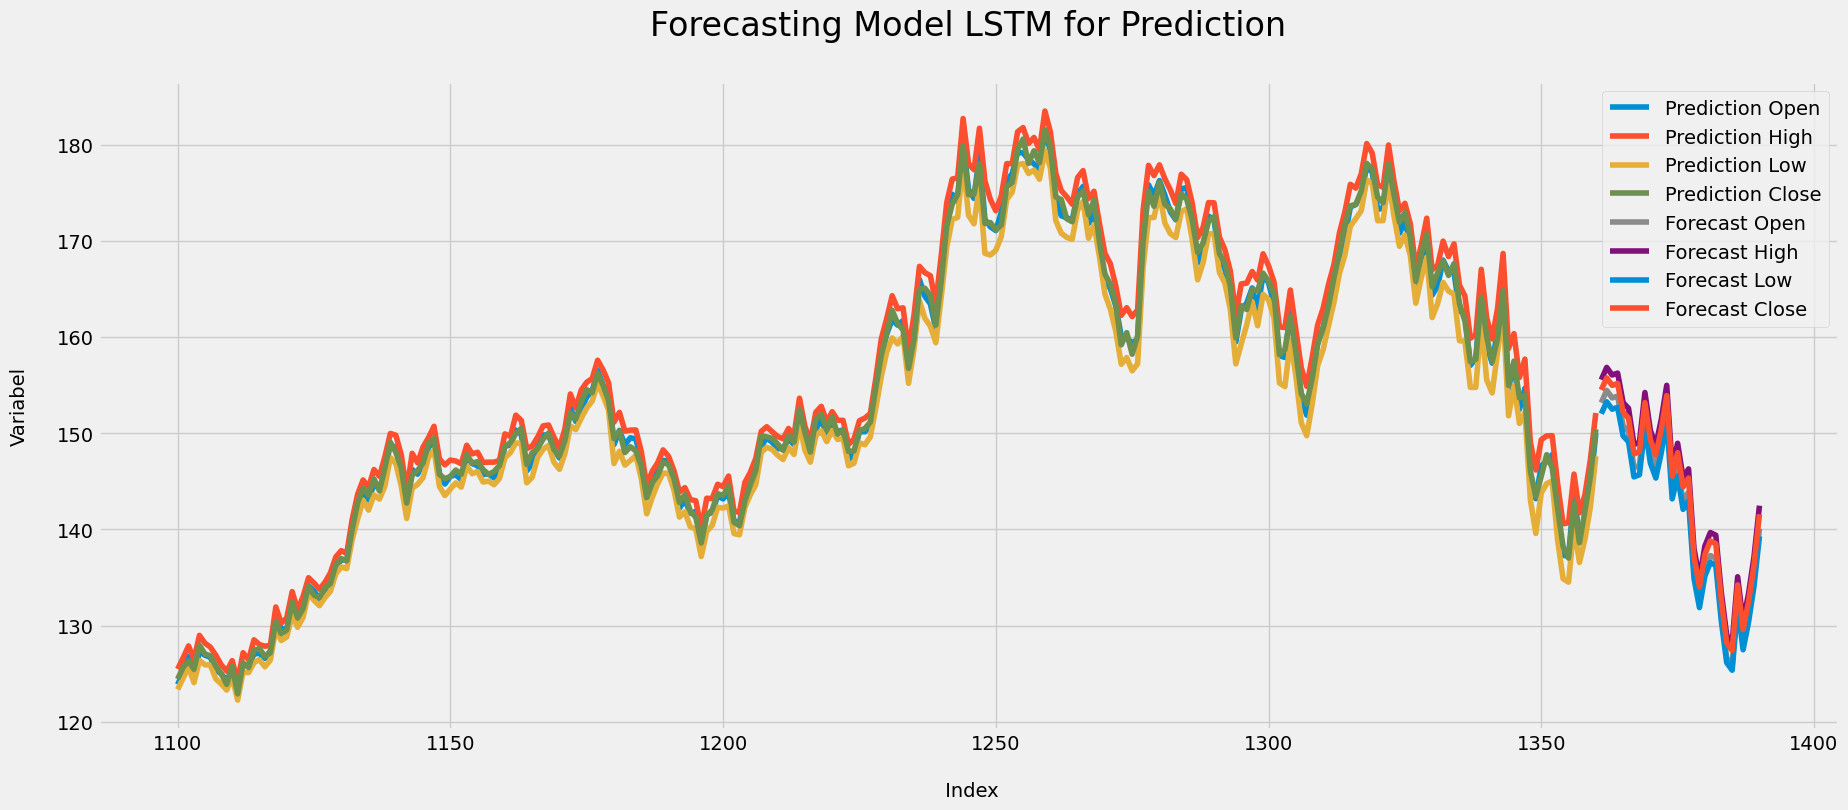

In [ ]:
# Visualization
plt.figure(figsize = (20,8))
plt.plot(week_predict, prediction[1100:], label = ['Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Close'])
plt.plot(week_forecast, output_forecast_prediction, label = ['Forecast Open', 'Forecast High', 'Forecast Low', 'Forecast Close' ])
plt.xlabel('\n Index', fontsize = 14)
plt.ylabel('Variabel\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM for Prediction\n', fontsize = 24)

### **Model 2 LSTM input Residual VARIMA**

In [ ]:
residual

Open      High       Low     Close
Date                                              
2017-01-04 -0.075241 -0.044728  0.160870 -0.120825
2017-01-05 -0.068976 -0.003157  0.017145 -0.014912
2017-01-06  0.041682  0.180484  0.067720  0.193113
2017-01-09  0.039569  0.191043  0.173308  0.179631
2017-01-10 -0.064203 -0.131772 -0.058685 -0.101510
...              ...       ...       ...       ...
2022-05-24 -2.925886 -3.781363 -3.014416 -2.403735
2022-05-25 -0.658226  0.069999  1.784457  1.913966
2022-05-26 -3.277853  0.758345 -1.821943  1.879848
2022-05-27  0.989119  2.435490  2.950186  4.200541
2022-05-31 -0.900239 -1.434738 -0.771356 -1.575061

[1361 rows x 4 columns]

In [ ]:
residual.shape

(1361, 4)

### **Splitting Data 80:20**

In [ ]:
training_portion = .8

#train size
training_size = int(len(residual) * training_portion)

training_data_residual = residual[0: train_size]
testing_data_residual = residual[train_size:]

print("train_data: ", training_data_residual.shape)
print("test_data: ", testing_data_residual.shape)

train_data:  (1088, 4)
test_data:  (273, 4)


In [ ]:
# Standard Scaler
scaler = MinMaxScaler()

# Data Train
training_residual_scale = pd.DataFrame(scaler.fit_transform(training_data_residual), columns = ['Res Open',	'Res High',	'Res Low','Res Close'])
testing_residual_scale = pd.DataFrame(scaler.fit_transform(testing_data_residual), columns = ['Res Open',	'Res High',	'Res Low','Res Close'])

In [ ]:
train_data_residual = np.array(training_residual_scale)
test_data_residual = np.array(testing_residual_scale)

In [ ]:
def create_dataset(dataset, time_steps):
    dataX = []
    dataY = []
    for i in range(time_steps, len(dataset)):
            dataX.append(dataset[i - time_steps:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 5
X_train_residual, y_train_residual = create_dataset(train_data_residual, time_steps)
X_test_residual, y_test_residual = create_dataset(test_data_residual, time_steps)

### **Hypertuning menggunakan Grid Search**

In [ ]:
def create_model(LSTM_unit, dropout):
  # create model
  model = Sequential()
  model.add(LSTM(units = LSTM_unit, input_shape = (time_steps, 4), return_sequences = True ))
  model.add(Dropout(dropout))
  model.add(BatchNormalization())
  model.add(LSTM(units = LSTM_unit))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(4))

  # compile model
  model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

  return model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#create model
model = KerasRegressor(build_fn = create_model, validation_split = 0.25, callbacks = [es], epochs = 100, verbose = 1)
LSTM_unit = [32, 64, 128]
batch_size = [16, 32, 64, 128]
dropout = [0.1, 0.2, 0.3]
param_grid = dict(batch_size = batch_size, LSTM_unit = LSTM_unit, dropout = dropout)

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 3, cv = 5, verbose = 1)

In [ ]:
%%time
grid_result = grid.fit(X_train_residual, y_train_residual, validation_split = 0.25, verbose = 1, callbacks = [es])

Fitting 5 folds for each of 36 candidates, totalling 180 fits


KeyboardInterrupt: ignored

### **Membangun Model LSTM untuk Data Residual**

In [ ]:
seed = 123
np.random.seed(seed)

In [ ]:
# Build model
model_residual = Sequential()
model_residual.add(LSTM(units = 64, input_shape = (time_steps, 4), activation = 'tanh' ))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.1))
model_residual.add(Dense(units = 32, activation = 'sigmoid'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.1))
model_residual.add(Dense(units = 16, activation = 'sigmoid'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.1))
model_residual.add(Dense(4, activation = 'sigmoid'))

# Compile model
model_residual.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
%%time
#Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#Fit Model
history_residual = model_residual.fit(X_train_residual, y_train_residual, epochs = 100, batch_size = 16, verbose = 1, validation_data = (X_test_residual, y_test_residual), callbacks = [es])

Epoch 1/100
68/68 [==============================] - 5s 15ms/step - loss: 0.0260 - val_loss: 0.0264
Epoch 2/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0169 - val_loss: 0.0199
Epoch 3/100
68/68 [==============================] - 0s 7ms/step - loss: 0.0153 - val_loss: 0.0157
Epoch 4/100
68/68 [==============================] - 1s 7ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 5/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 0.0131
Epoch 6/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0116 - val_loss: 0.0137
Epoch 7/100
68/68 [==============================] - 1s 8ms/step - loss: 0.0111 - val_loss: 0.0129
Epoch 8/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0101 - val_loss: 0.0130
Epoch 9/100
68/68 [==============================] - 1s 9ms/step - loss: 0.0100 - val_loss: 0.0134
Epoch 10/100
68/68 [==============================] - 1s 10ms/step - loss: 0.0088 - val_loss: 0.0136
Epoch 

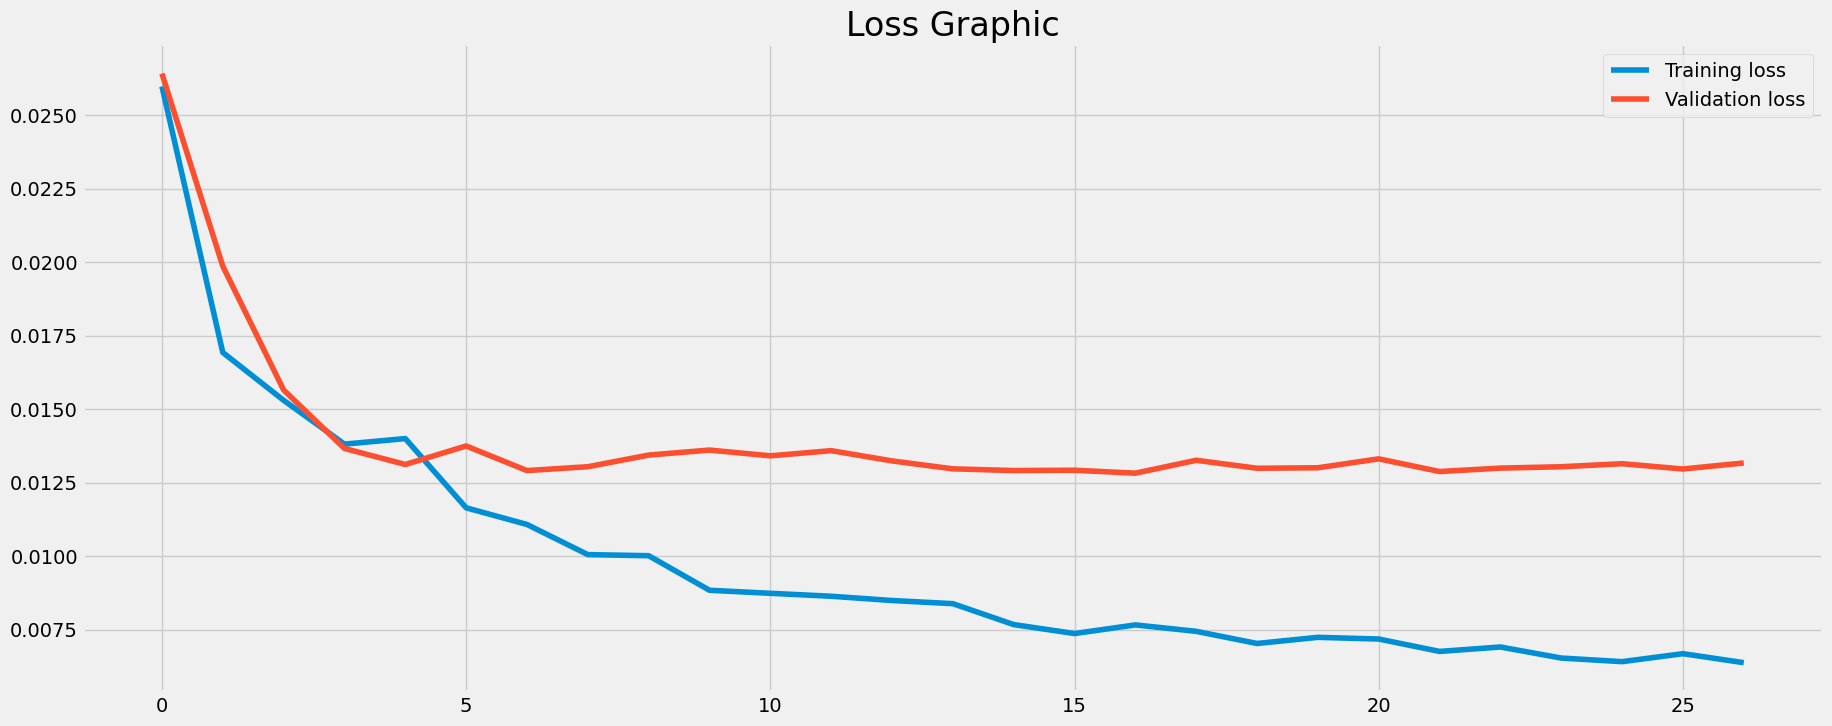

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(history_residual.history['loss'], label = 'Training loss')
plt.plot(history_residual.history['val_loss'], label = 'Validation loss')
plt.title('Loss Graphic', fontsize = 24)
plt.legend()

In [ ]:
test_predict_2 = model_residual.predict(X_test_residual)

9/9 [==============================] - 1s 4ms/step


In [ ]:
test_data_residual = np.array(testing_data_residual[5:])
test_data_residual = pd.DataFrame(test_data_residual, columns = ['Res Open', 'Res High', 'Res Low', 'Res Close'])
test_data_residual

Res Open  Res High   Res Low  Res Close
0   -0.910094 -1.969619 -1.925940  -3.048921
1   -3.314504 -2.143111 -2.910074  -1.171346
2   -2.916018 -2.802553 -2.483153  -3.526454
3    1.856577  1.761111  2.306808   2.062303
4    1.064403  1.067711  1.203790   1.527991
..        ...       ...       ...        ...
263 -2.925886 -3.781363 -3.014416  -2.403735
264 -0.658226  0.069999  1.784457   1.913966
265 -3.277853  0.758345 -1.821943   1.879848
266  0.989119  2.435490  2.950186   4.200541
267 -0.900239 -1.434738 -0.771356  -1.575061

[268 rows x 4 columns]

In [ ]:
test_model_residual = scaler.inverse_transform(test_predict_2)
test_model_residual

array([[ 0.04444028,  2.0373163 , -0.5416818 ,  1.6866198 ],
       [-0.06297886,  1.965588  , -0.65176815,  1.7765945 ],
       [-0.43911475,  1.743805  , -1.2781492 ,  1.3023688 ],
       ...,
       [ 0.06243422,  2.019714  , -0.5045264 ,  1.8656956 ],
       [-0.46357507,  1.6136012 , -0.81457156,  1.4397889 ],
       [-0.47438046,  1.6270376 , -1.1319579 ,  0.88921076]],
      dtype=float32)

In [ ]:
test_model_residual = pd.DataFrame(test_model_residual, columns = ['Prediction Open', 'Prediction High', 'Prediction Low', 'Prediction Close'])
test_model_residual

Prediction Open  Prediction High  Prediction Low  Prediction Close
0           0.044440         2.037316       -0.541682          1.686620
1          -0.062979         1.965588       -0.651768          1.776595
2          -0.439115         1.743805       -1.278149          1.302369
3          -0.116453         1.936026       -0.738456          1.737459
4           0.017492         1.975233       -0.536256          1.899868
..               ...              ...             ...               ...
263         0.003544         1.918146       -0.663972          1.993261
264         0.030520         1.997725       -0.501065          1.905184
265         0.062434         2.019714       -0.504526          1.865696
266        -0.463575         1.613601       -0.814572          1.439789
267        -0.474380         1.627038       -1.131958          0.889211

[268 rows x 4 columns]

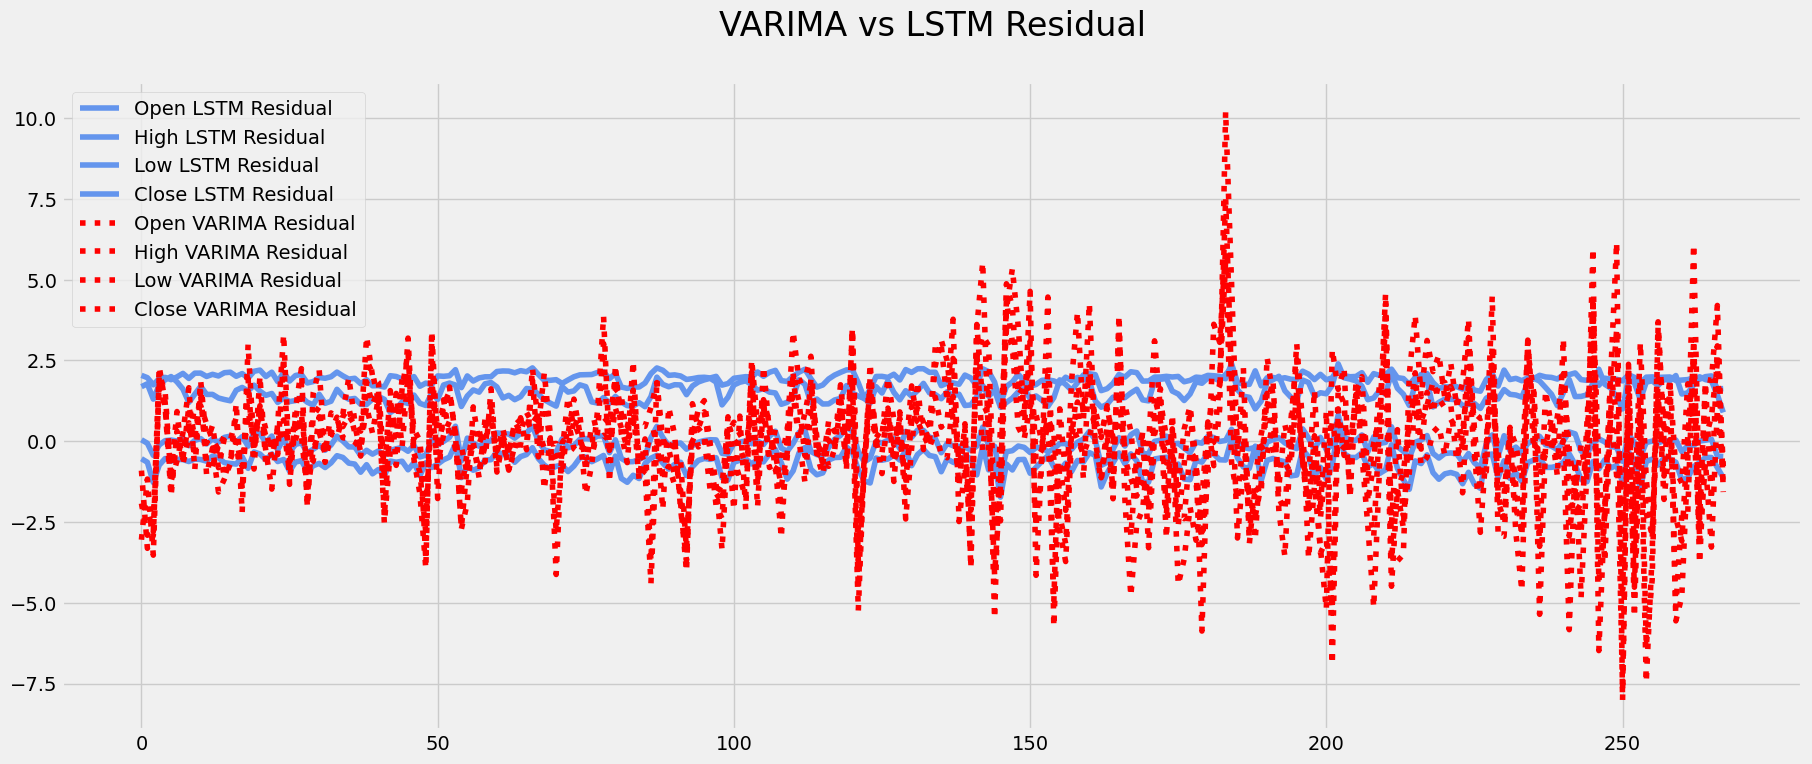

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(test_model_residual, label = ('Open LSTM Residual', 'High LSTM Residual','Low LSTM Residual', 'Close LSTM Residual'), color = 'cornflowerblue')
plt.plot(test_data_residual, label = ('Open VARIMA Residual', 'High VARIMA Residual','Low VARIMA Residual', 'Close VARIMA Residual'), linestyle = 'dotted', color='red')
plt.title('VARIMA vs LSTM Residual\n', fontsize = 24)
plt.legend()
plt.show()

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(test_data_residual, test_model_residual)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(test_data_residual, test_model_residual)
mae = mean_absolute_error(test_data_residual, test_model_residual)
akurasi = 100 - mape
print("MSE LSTM model 2  is %.2f" % mse)
print("RMSE LSTM model 2 is %.2f" % rmse)
print("MAPE LSTM model 2 is %.2f" % mape)
print("MAE LSTM model 2 is %.2f" % mae)
print("Accuracy LSTM model 2 is %.2f" % akurasi)

MSE LSTM model 2  is 5.60
RMSE LSTM model 2 is 2.37
MAPE LSTM model 2 is 6.17
MAE LSTM model 2 is 1.83
Accuracy LSTM model 2 is 93.83


### **Peramalan Residual**

In [ ]:
residual_scale = pd.DataFrame(scaler.fit_transform(residual), columns = ['Res Open', 'Res High', 'Res Low', 'Res Close'])
residual_scale

Res Open  Res High   Res Low  Res Close
0     0.531536  0.386091  0.592707   0.433861
1     0.532023  0.388990  0.581905   0.439672
2     0.540636  0.401799  0.585706   0.451084
3     0.540472  0.402536  0.593642   0.450344
4     0.532395  0.380020  0.576206   0.434921
...        ...       ...       ...        ...
1356  0.309660  0.125468  0.354063   0.308620
1357  0.486160  0.394093  0.714731   0.545490
1358  0.282265  0.442104  0.443686   0.543619
1359  0.614378  0.559081  0.802343   0.670933
1360  0.467323  0.289140  0.522644   0.354081

[1361 rows x 4 columns]

In [ ]:
time_steps = 30
input_residual = residual_scale.tail(time_steps)
input_residual

Res Open  Res High   Res Low  Res Close
1331  0.518099  0.416435  0.613797   0.481165
1332  0.597459  0.313788  0.612906   0.403119
1333  0.699262  0.610191  0.666320   0.441667
1334  0.516975  0.262875  0.360107   0.120551
1335  0.414182  0.234003  0.494333   0.407761
1336  0.527549  0.254885  0.367155   0.175145
1337  0.448935  0.383922  0.626908   0.393616
1338  0.653224  0.686958  0.894080   0.768091
1339  0.319240  0.331354  0.254135   0.085015
1340  0.354079  0.128874  0.411319   0.328034
1341  0.605404  0.453234  0.741271   0.553797
1342  0.453844  0.629549  0.638245   0.778101
1343  0.339339  0.068659  0.000000   0.000000
1344  0.643178  0.433947  0.759465   0.567664
1345  0.348324  0.074108  0.320865   0.142195
1346  0.775069  0.455778  0.724675   0.487008
1347  0.446174  0.232453  0.104521   0.031254
1348  0.302438  0.188620  0.258610   0.248974
1349  0.646650  0.523933  0.846018   0.643204
1350  0.453656  0.263523  0.610457   0.440910
1351  0.679679  0.392667  0.724754   0.521564
1352  0.465803  0.223264  0.195442   0.135461
1353  0.436513  0.173717  0.410080   0.176845
1354  0.675478  0.397897  0.410574   0.405816
1355  0.583506  0.567970  0.816419   0.774848
1356  0.309660  0.125468  0.354063   0.308620
1357  0.486160  0.394093  0.714731   0.545490
1358  0.282265  0.442104  0.443686   0.543619
1359  0.614378  0.559081  0.802343   0.670933
1360  0.467323  0.289140  0.522644   0.354081

In [ ]:
x_input_residual = np.array(input_residual).reshape(1,-1)
x_input_residual = x_input_residual.reshape((time_steps, 1, 4))
x_input_residual

array([[[0.51809891, 0.41643502, 0.61379717, 0.48116477]],

       [[0.59745873, 0.31378788, 0.61290566, 0.40311888]],

       [[0.69926171, 0.61019099, 0.66631968, 0.44166739]],

       [[0.51697477, 0.26287493, 0.36010746, 0.12055087]],

       [[0.41418163, 0.23400274, 0.49433303, 0.40776068]],

       [[0.52754911, 0.25488533, 0.36715532, 0.17514465]],

       [[0.44893516, 0.38392226, 0.62690844, 0.39361578]],

       [[0.65322355, 0.68695814, 0.89407977, 0.76809103]],

       [[0.31924037, 0.33135366, 0.25413487, 0.08501534]],

       [[0.35407894, 0.12887435, 0.41131878, 0.3280341 ]],

       [[0.60540434, 0.45323412, 0.74127147, 0.55379666]],

       [[0.45384441, 0.62954921, 0.63824507, 0.77810147]],

       [[0.33933851, 0.06865935, 0.        , 0.        ]],

       [[0.64317791, 0.43394705, 0.7594646 , 0.56766421]],

       [[0.34832384, 0.07410769, 0.32086541, 0.14219531]],

       [[0.7750691 , 0.45577763, 0.72467454, 0.4870075 ]],

       [[0.446174  , 0.23245255, 0.10452

In [ ]:
daily_input_residual = list(x_input_residual)
daily_input_residual = daily_input_residual[0].tolist()
daily_input_residual

[[0.5180989086950208,
  0.4164350240948617,
  0.6137971726874296,
  0.48116477433451077]]

In [ ]:
yhat_residual = model_prediction.predict(x_input_residual)
yhat_residual

1/1 [==============================] - 0s 33ms/step


array([[0.42982867, 0.43456435, 0.4336864 , 0.4355228 ],
       [0.42565766, 0.4288061 , 0.4268334 , 0.42934355],
       [0.49000582, 0.49826396, 0.49207157, 0.4972564 ],
       [0.20594753, 0.21103586, 0.20546573, 0.20785385],
       [0.31358415, 0.31650424, 0.31712514, 0.31707215],
       [0.22566855, 0.23046422, 0.22561954, 0.22780259],
       [0.36966154, 0.37492907, 0.37233448, 0.37429196],
       [0.72077715, 0.72529835, 0.7258143 , 0.7292053 ],
       [0.13587344, 0.1409298 , 0.13699105, 0.13808988],
       [0.23751822, 0.24002859, 0.24036069, 0.23981565],
       [0.55493367, 0.558401  , 0.55822444, 0.5609266 ],
       [0.5564544 , 0.56268215, 0.5670956 , 0.5674382 ],
       [0.09286779, 0.09576683, 0.09388664, 0.09402069],
       [0.584489  , 0.58707833, 0.58734024, 0.59015495],
       [0.16444719, 0.16747837, 0.16535988, 0.16566244],
       [0.5771152 , 0.58048874, 0.57774884, 0.5822349 ],
       [0.12366053, 0.1278064 , 0.12416952, 0.12523341],
       [0.16531052, 0.16896442,

### **Peramalan Data Residual**

In [ ]:
# Peramalan
from numpy import array

output_peramalan_residual = []
time_steps = 30
i = 0

#print(daily_input)
print("{} daily input {}".format(i, daily_input_residual))

#print(x_input)
print("{} daily output {}".format(i, yhat_residual))
daily_input_residual.extend(yhat_residual.tolist())
daily_input_residual = daily_input_residual[1:]

#print(daily_input)
output_peramalan_residual.extend(yhat_residual.tolist())
i = i+1

print(output_peramalan_residual)

0 daily input [[0.5180989086950208, 0.4164350240948617, 0.6137971726874296, 0.48116477433451077]]
0 daily output [[0.42982867 0.43456435 0.4336864  0.4355228 ]
 [0.42565766 0.4288061  0.4268334  0.42934355]
 [0.49000582 0.49826396 0.49207157 0.4972564 ]
 [0.20594753 0.21103586 0.20546573 0.20785385]
 [0.31358415 0.31650424 0.31712514 0.31707215]
 [0.22566855 0.23046422 0.22561954 0.22780259]
 [0.36966154 0.37492907 0.37233448 0.37429196]
 [0.72077715 0.72529835 0.7258143  0.7292053 ]
 [0.13587344 0.1409298  0.13699105 0.13808988]
 [0.23751822 0.24002859 0.24036069 0.23981565]
 [0.55493367 0.558401   0.55822444 0.5609266 ]
 [0.5564544  0.56268215 0.5670956  0.5674382 ]
 [0.09286779 0.09576683 0.09388664 0.09402069]
 [0.584489   0.58707833 0.58734024 0.59015495]
 [0.16444719 0.16747837 0.16535988 0.16566244]
 [0.5771152  0.58048874 0.57774884 0.5822349 ]
 [0.12366053 0.1278064  0.12416952 0.12523341]
 [0.16531052 0.16896442 0.16792263 0.16768475]
 [0.6539588  0.65703094 0.6574699  0.6606

In [ ]:
output_forecast_residual = pd.DataFrame(output_peramalan_residual, columns = ['Forecast Res Open', 'Forecast Res High', 'Forecast Res Low', 'Forecast Res Close'])
output_forecast_residual

Forecast Res Open  Forecast Res High  Forecast Res Low  Forecast Res Close
0            0.429829           0.434564          0.433686            0.435523
1            0.425658           0.428806          0.426833            0.429344
2            0.490006           0.498264          0.492072            0.497256
3            0.205948           0.211036          0.205466            0.207854
4            0.313584           0.316504          0.317125            0.317072
5            0.225669           0.230464          0.225620            0.227803
6            0.369662           0.374929          0.372334            0.374292
7            0.720777           0.725298          0.725814            0.729205
8            0.135873           0.140930          0.136991            0.138090
9            0.237518           0.240029          0.240361            0.239816
10           0.554934           0.558401          0.558224            0.560927
11           0.556454           0.562682          0.567096            0.567438
12           0.092868           0.095767          0.093887            0.094021
13           0.584489           0.587078          0.587340            0.590155
14           0.164447           0.167478          0.165360            0.165662
15           0.577115           0.580489          0.577749            0.582235
16           0.123661           0.127806          0.124170            0.125233
17           0.165311           0.168964          0.167923            0.167685
18           0.653959           0.657031          0.657470            0.660603
19           0.388271           0.390726          0.391396            0.391960
20           0.561821           0.564080          0.563662            0.566742
21           0.160770           0.165019          0.161606            0.162696
22           0.215175           0.219020          0.215463            0.216802
23           0.367167           0.372317          0.369494            0.372163
24           0.679523           0.682678          0.685690            0.687721
25           0.203700           0.206488          0.206725            0.205995
26           0.494947           0.498065          0.499314            0.500561
27           0.301384           0.307151          0.309345            0.308234
28           0.636901           0.640809          0.641736            0.644502
29           0.320343           0.324457          0.322499            0.323840

Text(0.5, 1.0, 'Forecasting Model LSTM for Residual\n')

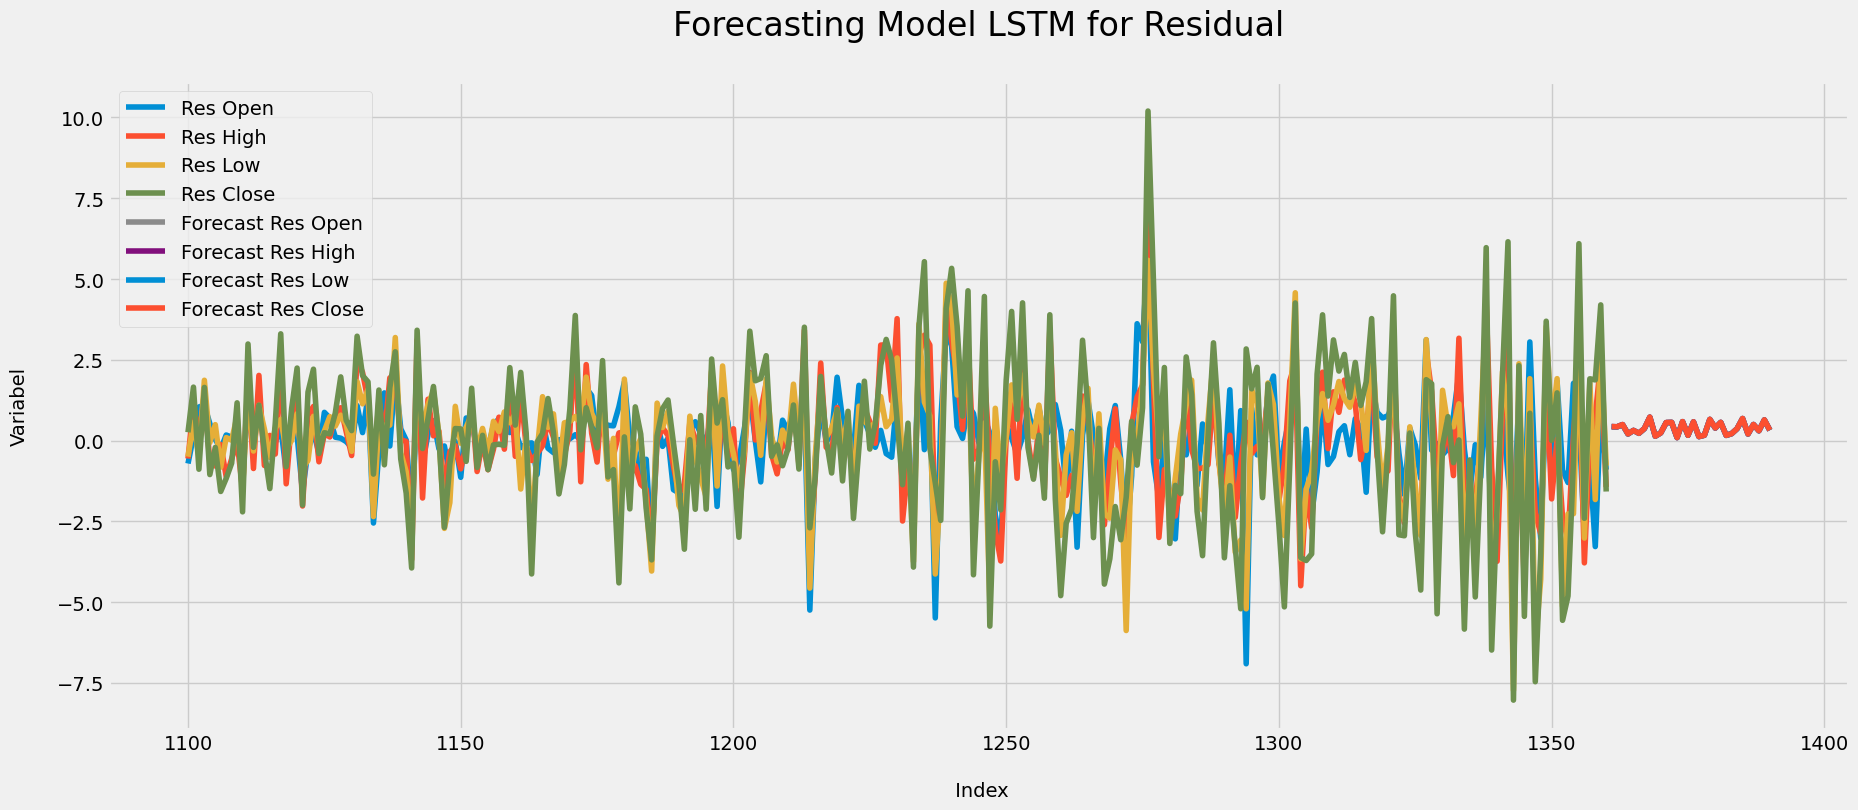

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(week_predict, residual[1100:], label = ['Res Open', 'Res High', 'Res Low', 'Res Close'])
plt.plot(week_forecast , output_forecast_residual, label = ['Forecast Res Open', 'Forecast Res High', 'Forecast Res Low', 'Forecast Res Close'])
plt.xlabel('\n Index', fontsize = 14)
plt.ylabel('Variabel\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM for Residual\n', fontsize = 24)

## **MODEL HYBRID**

In [ ]:
prediction_hybrid = test_model_prediction + test_model_residual
prediction_hybrid = pd.DataFrame(prediction_hybrid)
prediction_hybrid

Prediction Open  Prediction High  Prediction Low  Prediction Close
0         129.822525       133.353760      128.322525        131.591202
1         129.759293       133.335083      128.261887        131.736649
2         128.005203       131.740570      126.307190        129.902649
3         127.627663       131.224091      126.157623        129.630630
4         126.490334       129.999176      125.124336        128.535355
..               ...              ...             ...               ...
263       137.124344       140.799973      135.416962        139.289749
264       141.672043       145.445114      140.018433        143.759628
265       139.756912       143.503479      138.132507        141.792694
266       140.900040       144.775803      139.482025        143.057098
267       144.131866       148.092178      142.377625        145.794067

[268 rows x 4 columns]

In [ ]:
data_hybrid = data[1094:]
data_hybrid

Open        High         Low       Close
Date                                                      
2021-05-10  129.410004  129.539993  126.809998  126.849998
2021-05-11  123.500000  126.269997  122.769997  125.910004
2021-05-12  123.400002  124.639999  122.250000  122.769997
2021-05-13  124.580002  126.150002  124.260002  124.970001
2021-05-14  126.250000  127.889999  125.849998  127.449997
...                ...         ...         ...         ...
2022-05-24  140.809998  141.970001  137.330002  140.360001
2022-05-25  138.429993  141.789993  138.339996  140.520004
2022-05-26  137.389999  144.339996  137.139999  143.779999
2022-05-27  145.389999  149.679993  145.259995  149.639999
2022-05-31  149.070007  150.660004  146.839996  148.839996

[268 rows x 4 columns]

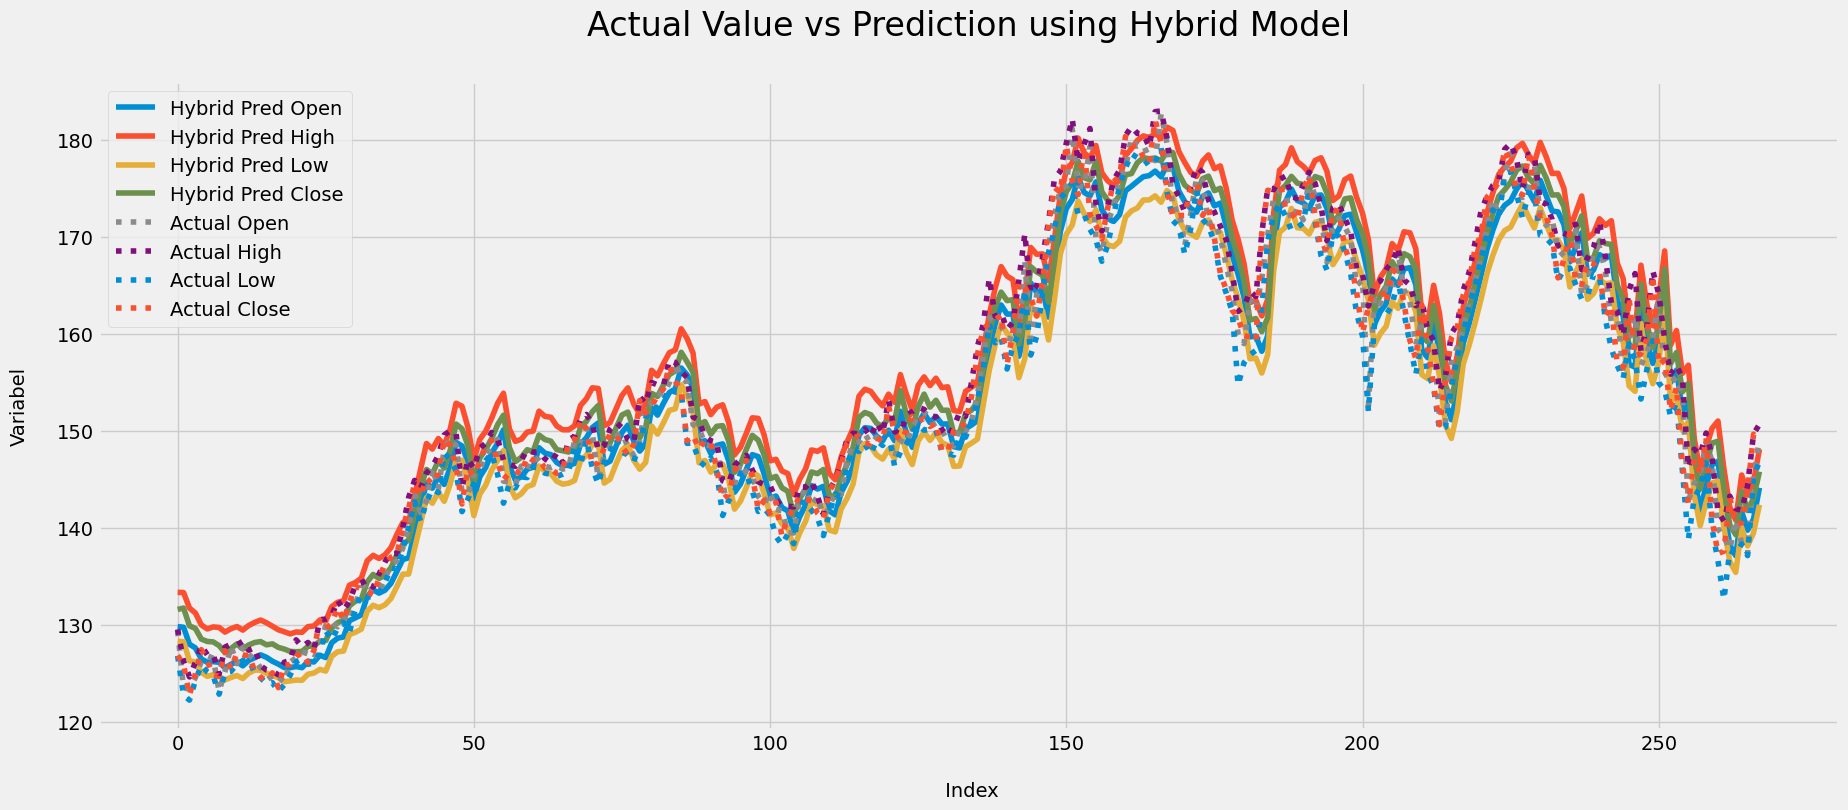

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(np.array(prediction_hybrid), label = ['Hybrid Pred Open', 'Hybrid Pred High', 'Hybrid Pred Low', 'Hybrid Pred Close'])
plt.plot(np.array(data_hybrid), label = ['Actual Open', 'Actual High', 'Actual Low', 'Actual Close'], linestyle = 'dotted')
plt.title('Actual Value vs Prediction using Hybrid Model\n', fontsize = 24)
plt.xlabel('\n Index', fontsize = 14)
plt.ylabel('Variabel\n', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
forecasting_hybrid = output_forecast_prediction['Forecast Open'] + output_forecast_residual['Forecast Res Open']
forecasting_hybrid = pd.DataFrame(forecasting_hybrid, columns = ['Forecast Hybrid Open'])
forecasting_hybrid['Forecast Hybrid High'] = output_forecast_prediction['Forecast High'] + output_forecast_residual['Forecast Res High']
forecasting_hybrid['Forecast Hybrid Low'] = output_forecast_prediction['Forecast Low'] + output_forecast_residual['Forecast Res Low']
forecasting_hybrid['Forecast Hybrid Close'] = output_forecast_prediction['Forecast Close'] + output_forecast_residual['Forecast Res Close']
forecasting_hybrid

Forecast Hybrid Open  Forecast Hybrid High  Forecast Hybrid Low  \
0             153.597388            155.985447           152.457727   
1             154.874363            157.262389           153.684128   
2             154.153232            156.544632           152.982377   
3             154.055017            156.454619           152.892412   
4             151.097479            153.504104           150.034686   
5             150.399813            152.805337           149.333627   
6             146.777791            149.192684           145.829381   
7             147.359118            149.774051           146.406043   
8             151.960515            154.368790           150.852802   
9             148.122734            150.537156           147.148090   
10            146.839773            149.253230           145.897374   
11            149.566445            151.979280           148.540869   
12            152.660310            155.070244           151.525732   
13            144.636555            147.072666           143.761164   
14            146.698475            149.115591           145.744521   
15            143.517120            145.928045           142.661527   
16            143.985530            146.410301           143.094288   
17            135.759192            138.168247           135.078742   
18            133.135452            135.532544           132.527628   
19            136.249679            138.658764           135.545800   
20            137.840916            140.236410           137.120155   
21            137.157796            139.560114           136.418155   
22            131.310528            133.701148           130.728519   
23            127.010032            129.375481           126.512736   
24            126.534483            128.910601           126.044575   
25            132.894712            135.282509           132.259235   
26            128.529806            130.900977           127.987622   
27            131.243410            133.616622           130.665280   
28            135.385921            137.774733           134.726847   
29            140.393095            142.789690           139.602190   

    Forecast Hybrid Close  
0              154.927166  
1              156.174134  
2              155.467350  
3              155.374349  
4              152.478631  
5              151.777897  
6              148.220521  
7              148.803297  
8              153.316014  
9              149.553567  
10             148.287629  
11             150.970914  
12             154.001228  
13             146.124647  
14             148.137830  
15             145.001144  
16             145.455831  
17             137.301677  
18             134.698697  
19             137.782562  
20             139.368100  
21             138.673222  
22             132.870370  
23             128.574363  
24             128.103544  
25             134.436122  
26             130.083481  
27             132.796409  
28             136.929838  
29             141.893751

In [ ]:
dataset_update = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/SKRIPSI MAHASISWA/2019/DEA SAFITRI/Apple update.csv", parse_dates = True, index_col = 0)
dataset_update

Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-06-01  149.899994  151.740005  147.679993  148.710007  147.827301   
2022-06-02  147.830002  151.270004  146.860001  151.210007  150.312454   
2022-06-03  146.899994  147.970001  144.460007  145.380005  144.517059   
2022-06-06  147.029999  148.570007  144.899994  146.139999  145.272537   
2022-06-07  144.350006  149.000000  144.100006  148.710007  147.827301   
...                ...         ...         ...         ...         ...   
2023-05-24  171.089996  172.419998  170.520004  171.839996  171.839996   
2023-05-25  172.410004  173.899994  171.690002  172.990005  172.990005   
2023-05-26  173.320007  175.770004  173.110001  175.429993  175.429993   
2023-05-30  176.960007  178.990005  176.570007  177.300003  177.300003   
2023-05-31  177.330002  179.350006  176.759995  177.250000  177.250000   

              Volume  
Date                  
2022-06-01  74286600  
2022-06-02  72348100  
2022-06-03  88570300  
2022-06-06  71598400  
2022-06-07  67808200  
...              ...  
2023-05-24  45143500  
2023-05-25  56058300  
2023-05-26  54835000  
2023-05-30  55964400  
2023-05-31  99625300  

[251 rows x 6 columns]

In [ ]:
data_update = dataset_update[['Open','High','Low','Close']]
data_update = data_update[0:30]
data_update

Open        High         Low       Close
Date                                                      
2022-06-01  149.899994  151.740005  147.679993  148.710007
2022-06-02  147.830002  151.270004  146.860001  151.210007
2022-06-03  146.899994  147.970001  144.460007  145.380005
2022-06-06  147.029999  148.570007  144.899994  146.139999
2022-06-07  144.350006  149.000000  144.100006  148.710007
2022-06-08  148.580002  149.869995  147.460007  147.960007
2022-06-09  147.080002  147.949997  142.529999  142.639999
2022-06-10  140.279999  140.759995  137.059998  137.130005
2022-06-13  132.869995  135.199997  131.440002  131.880005
2022-06-14  133.130005  133.889999  131.479996  132.759995
2022-06-15  134.289993  137.339996  132.160004  135.429993
2022-06-16  132.080002  132.389999  129.039993  130.059998
2022-06-17  130.070007  133.080002  129.809998  131.559998
2022-06-21  133.419998  137.059998  133.320007  135.869995
2022-06-22  134.789993  137.759995  133.910004  135.350006
2022-06-23  136.820007  138.589996  135.630005  138.270004
2022-06-24  139.899994  141.910004  139.770004  141.660004
2022-06-27  142.699997  143.490005  140.970001  141.660004
2022-06-28  142.130005  143.419998  137.320007  137.440002
2022-06-29  137.460007  140.669998  136.669998  139.229996
2022-06-30  137.250000  138.369995  133.770004  136.720001
2022-07-01  136.039993  139.039993  135.660004  138.929993
2022-07-05  137.770004  141.610001  136.929993  141.559998
2022-07-06  141.350006  144.119995  141.080002  142.919998
2022-07-07  143.289993  146.550003  143.279999  146.350006
2022-07-08  145.259995  147.550003  145.000000  147.039993
2022-07-11  145.669998  146.639999  143.779999  144.869995
2022-07-12  145.759995  148.449997  145.050003  145.860001
2022-07-13  142.990005  146.449997  142.119995  145.490005
2022-07-14  144.080002  148.949997  143.250000  148.470001

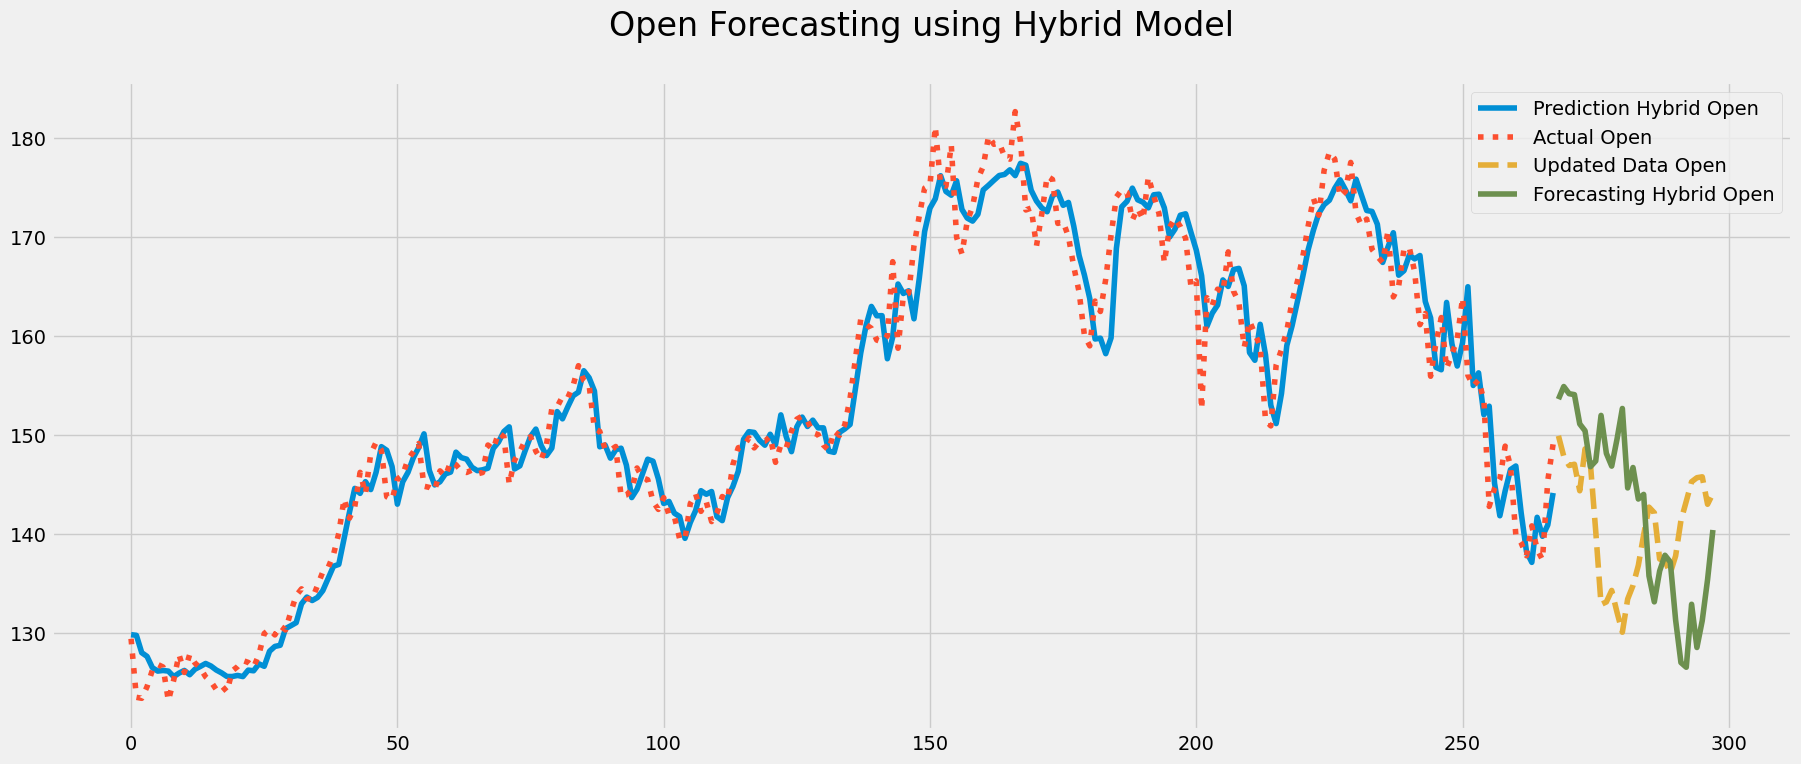

In [ ]:
#Open
plt.figure(figsize = (20,8))
plt.plot(np.array(prediction_hybrid['Prediction Open']), label = "Prediction Hybrid Open")
plt.plot(np.array(data_hybrid['Open']), label = "Actual Open", linestyle = 'dotted')
plt.plot(np.arange(268,298), data_update['Open'], label = 'Updated Data Open', linestyle = 'dashed')
plt.plot(np.arange(268,298), forecasting_hybrid['Forecast Hybrid Open'], label = 'Forecasting Hybrid Open')
plt.title('Open Forecasting using Hybrid Model\n', fontsize = 24)
plt.legend()
plt.show()

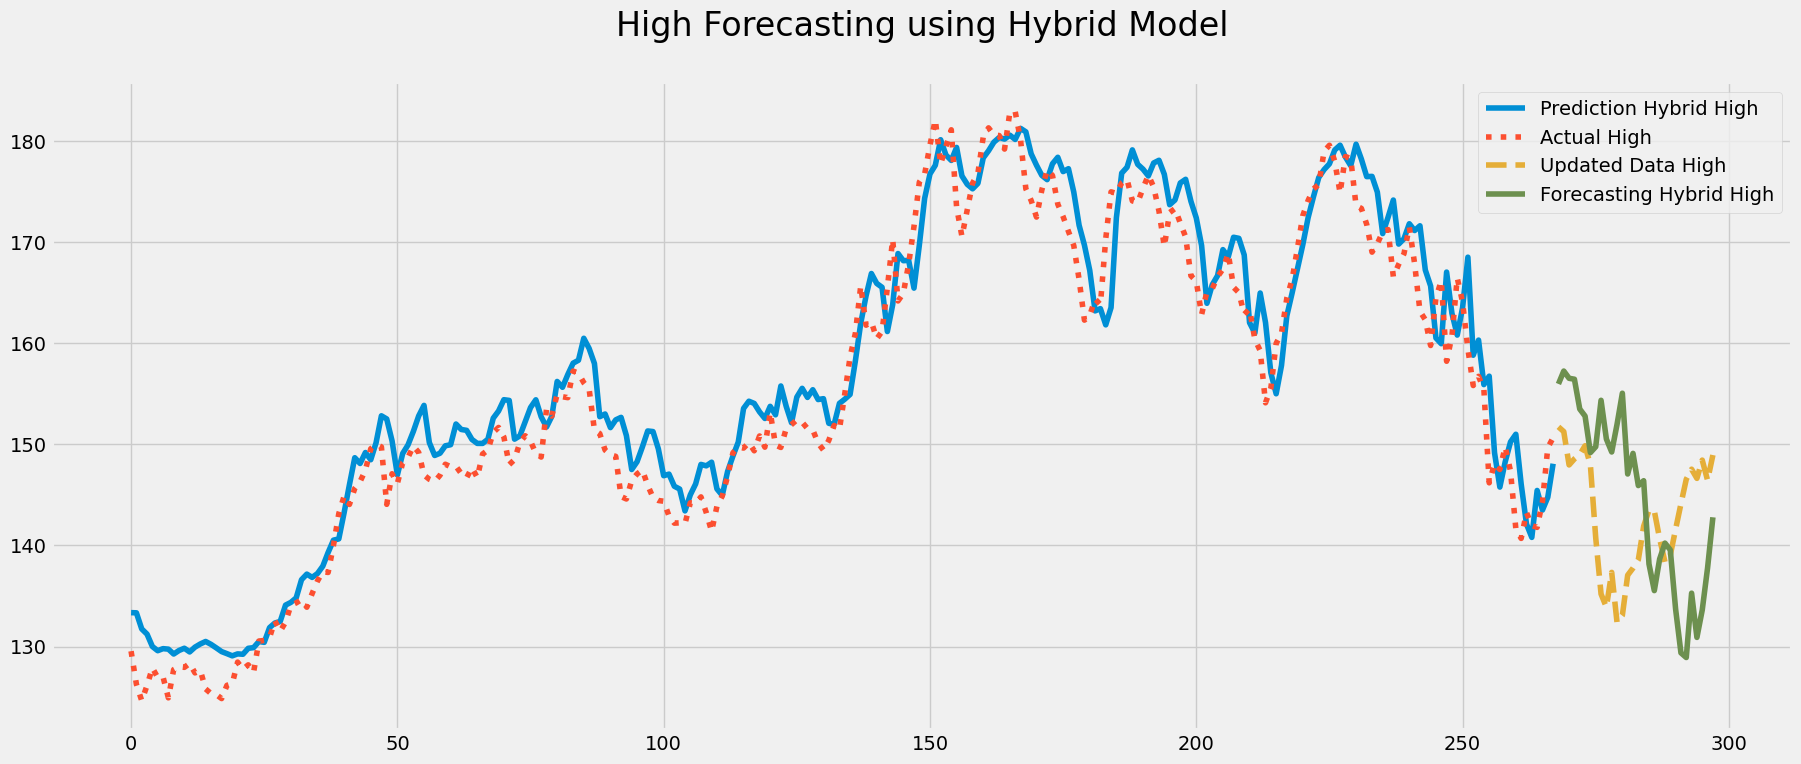

In [ ]:
#High
plt.figure(figsize = (20,8))
plt.plot(np.array(prediction_hybrid['Prediction High']), label = "Prediction Hybrid High")
plt.plot(np.array(data_hybrid['High']), label = "Actual High", linestyle = 'dotted')
plt.plot(np.arange(268,298), data_update['High'], label = 'Updated Data High', linestyle = 'dashed')
plt.plot(np.arange(268,298), forecasting_hybrid['Forecast Hybrid High'], label = 'Forecasting Hybrid High')
plt.title('High Forecasting using Hybrid Model\n', fontsize = 24)
plt.legend()
plt.show()

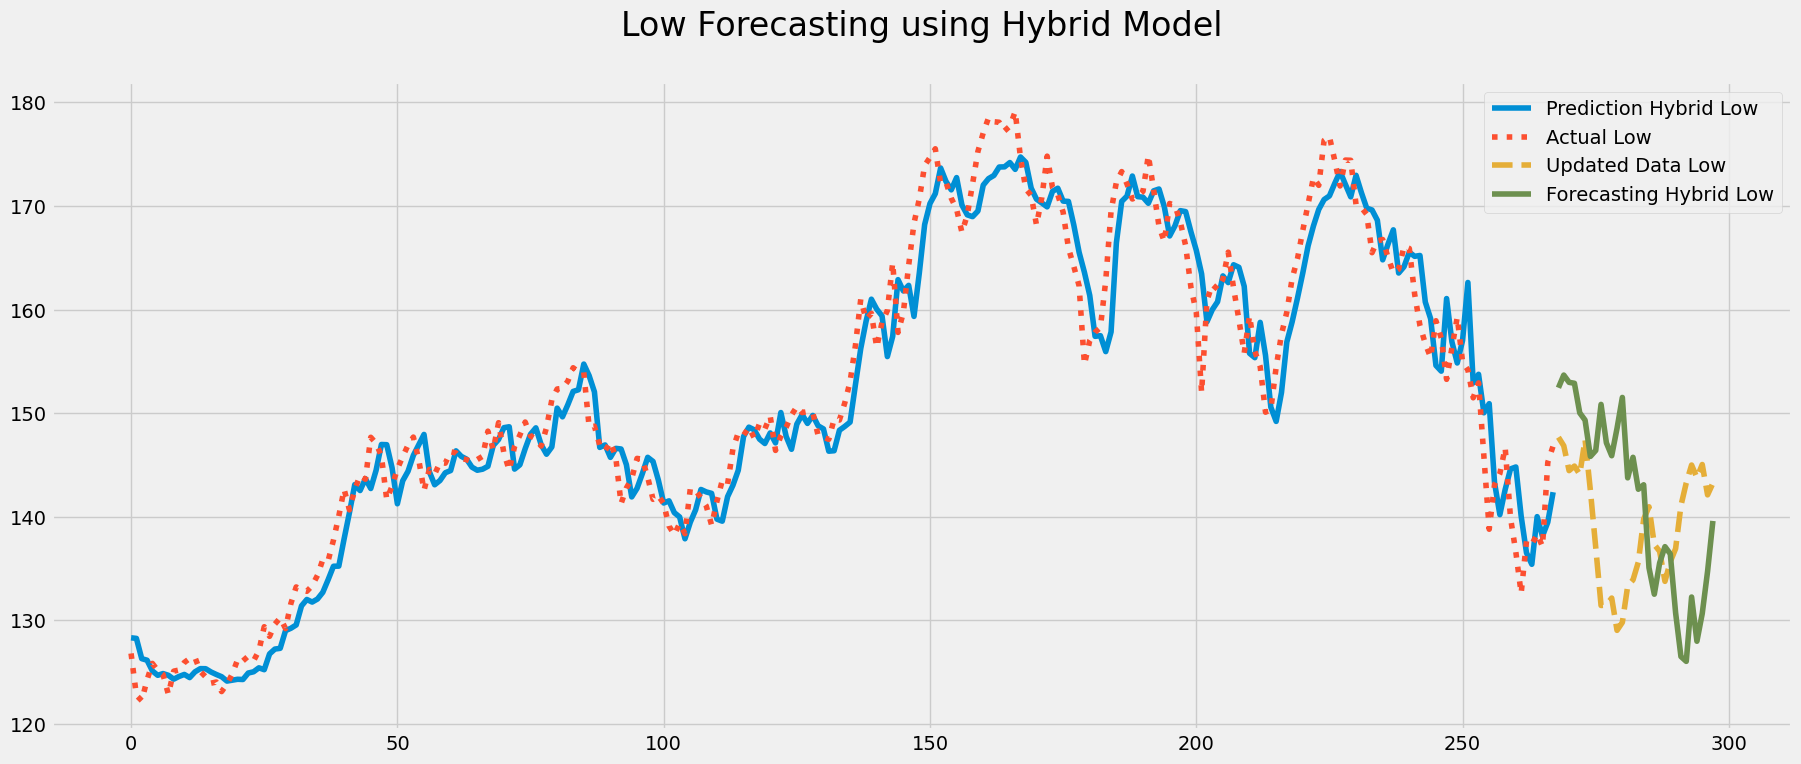

In [ ]:
#Low
plt.figure(figsize = (20,8))
plt.plot(np.array(prediction_hybrid['Prediction Low']), label = "Prediction Hybrid Low")
plt.plot(np.array(data_hybrid['Low']), label = "Actual Low", linestyle = 'dotted')
plt.plot(np.arange(268,298), data_update['Low'], label = 'Updated Data Low', linestyle = 'dashed')
plt.plot(np.arange(268,298), forecasting_hybrid['Forecast Hybrid Low'], label = 'Forecasting Hybrid Low')
plt.title('Low Forecasting using Hybrid Model\n', fontsize = 24)
plt.legend()
plt.show()

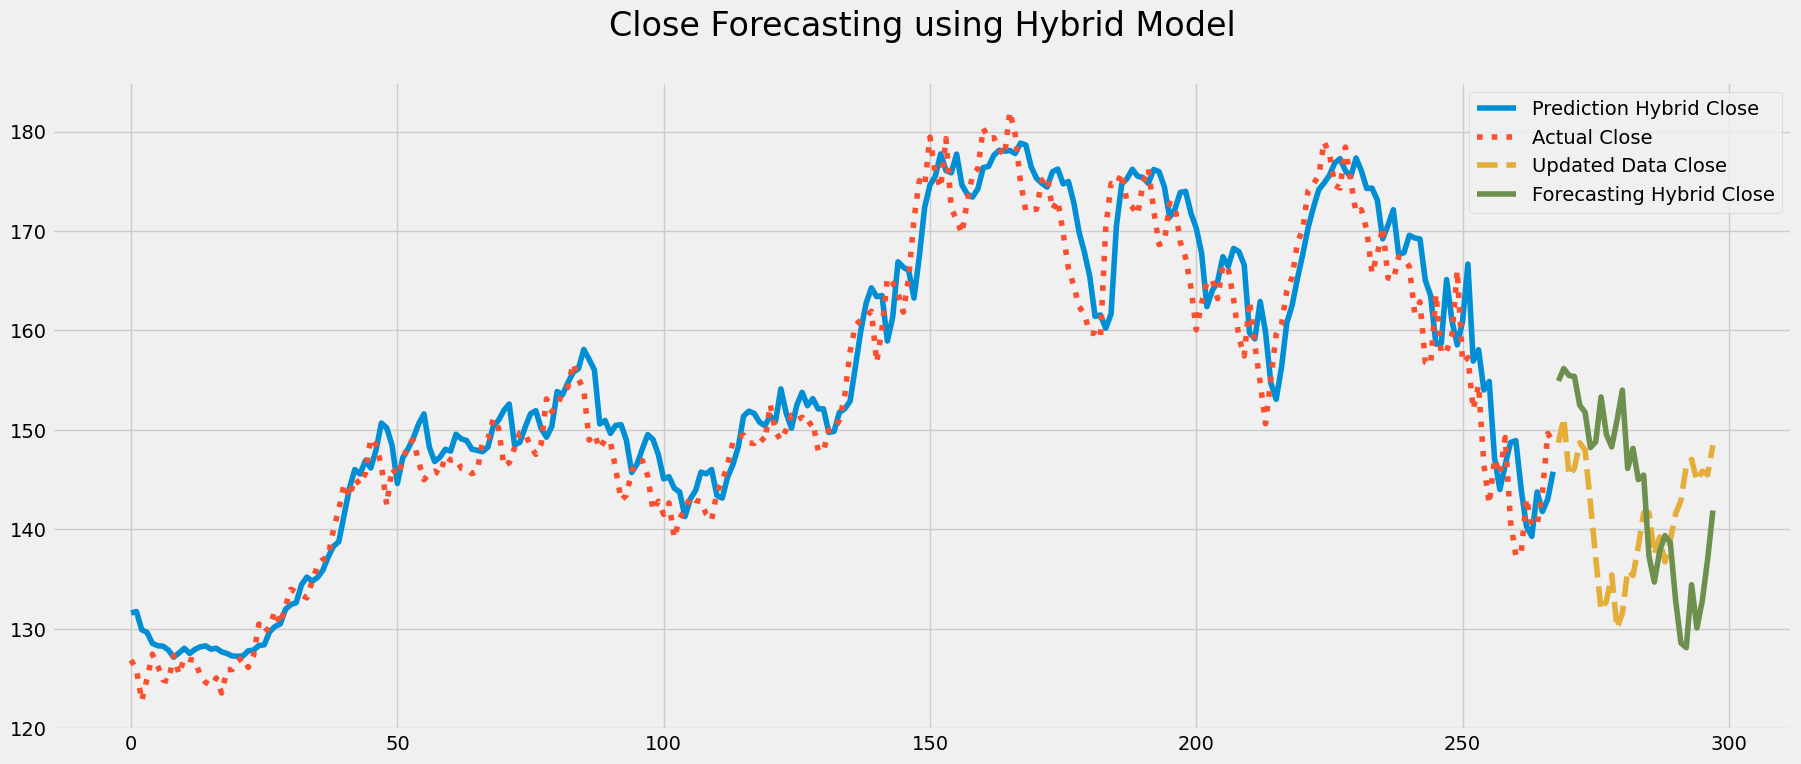

In [ ]:
#Close
plt.figure(figsize = (20,8))
plt.plot(np.array(prediction_hybrid['Prediction Close']), label = "Prediction Hybrid Close")
plt.plot(np.array(data_hybrid['Close']), label = "Actual Close", linestyle = 'dotted')
plt.plot(np.arange(268,298), data_update['Close'], label = 'Updated Data Close', linestyle = 'dashed')
plt.plot(np.arange(268,298), forecasting_hybrid['Forecast Hybrid Close'], label = 'Forecasting Hybrid Close')
plt.title('Close Forecasting using Hybrid Model\n', fontsize = 24)
plt.legend()
plt.show()

In [ ]:
# Accuracy Prediction Hybrid
mse = mean_squared_error(data_hybrid, prediction_hybrid)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_hybrid,prediction_hybrid)
mae = mean_absolute_error(data_hybrid,prediction_hybrid)
akurasi = 100 - mape
print("MSE Hybrid model 2  is %.2f" % mse)
print("RMSE Hybrid model 2 is %.2f" % rmse)
print("MAPE Hybrid model 2 is %.2f" % mape)
print("MAE Hybrid model 2 is %.2f" % mae)
print("Accuracy Hybrid model 2 is %.2f" % akurasi)

MSE Hybrid model 2  is 13.35
RMSE Hybrid model 2 is 3.65
MAPE Hybrid model 2 is 0.02
MAE Hybrid model 2 is 2.83
Accuracy Hybrid model 2 is 99.98
